In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MinuteLocator
import matplotlib 
from datetime import datetime, timedelta
import bisect
import netCDF4
from scipy import integrate, optimize, interpolate, stats
from matplotlib.colors import LogNorm

import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import pylab

import cartopy.crs as ccrs
import cartopy

In [6]:
# reading data and putting it into dictionaries 
def unwrap_slt(t, slt):
    '''
    Unwrap solar local time. slt can be 1D, or 2D (in which case its rows are unwrapped)
    This code is more complicated than simply removing negative jumps, because it needs to handle
    large data gaps.
    
    INPUTS:
    
      *  t        --TYPE:array(nt) of datetime                 Time
      *  slt      --TYPE:array(nt) or array(nt,nx). UNITS:hr.  Solar Local Time to be unwrapped
      
    OUTPUTS:
      * slt_u     --TYPE:same as slt.               UNITS:hr.  Unwrapped version of input slt.
    
    '''
    
    # In case input is a masked array, fill with nans
    slt = np.ma.filled(slt, np.nan)
    
    def unwrap_slt_1D(t, slt_1D, t0, slt0):
        '''Helper function to solve the 1D unwrapping problem
        t and slt_1D are as described above
        t0 and slt0 are scalars. Array will be unwrapped such that at time t0, the unwrapped slt
        will be within 12h of slt0'''
        # Find the average slope of the SLT vs t line
        
        time_sec = np.array([(ti - t0).total_seconds() for ti in t])
        def err(dslt_dt):
            slt_fit = np.mod(slt0 + dslt_dt*time_sec, 24.)
            return np.nanmean((slt_fit-slt_1D)**2)
        dslt_dt_min = 24./(1*3600)
        dslt_dt_max = 24./(2*3600)
        dslt_dt = optimize.brute(err, ranges=((dslt_dt_min,dslt_dt_max),), Ns=500, finish = optimize.fmin)[0]

        # Add or subtract 24 from the input array to get close to the unwrapped line
        slt_fit = slt0 + dslt_dt*time_sec
        d = slt_fit - slt_1D
        n = np.round(d/24.)
        slt_u = slt_1D + n*24.
        return slt_u
    
    # If input is already 1D, then simply call lower-level function
    if np.ndim(slt) == 1:
        k = np.where(np.isfinite(slt))[0][0] # find reference that's not nan
        return unwrap_slt_1D(t, slt, t[k], slt[k])
    
    # If input is 2D, then unwrap each row individually
    # Find a reference value to use 
    ij = np.where(np.isfinite(slt))
    i = ij[0][0]
    j = ij[1][0]
    t0 = t[j]
    slt0 = slt[i,j]
    slt_u = np.zeros_like(slt)
    for i in range(np.shape(slt)[0]):
        slt_u[i,:] = unwrap_slt_1D(t, slt[i,:], t0, slt0)
    return slt_u

def fill(x):
    '''
    If there are nans in the middle of the array x, fill them in with linear interpolation.
    
    INPUT:
     * x             --TYPE:array(nx).    Array with possible nans in the middle. Can also be of 
                                          type np.ma.MaskedArray. This array must not have nans at
                                          the beginning or end.
    
    OUTPUT:
     * x_filled      --TYPE:array(nx).    Copy of x with nans replaced with interpolated values
    '''
    
    y = np.ma.filled(x, np.nan).copy()
    n = np.arange(len(y))
    i = np.isfinite(y) # which indices are good
    # Interpolate between missing samples
    f = interpolate.interp1d(n[i], y[i])
    y[~i] = f(n[~i])
    return y

def mag_lines():
    '''
    Helper function to define magnetic latitude -10, 0, and 10 degrees.
    
    OUTPUTS:
    
    lonlat_m10 -- TYPE:array(n,2), UNITS:deg. Geographic Longitude and Latitude of MLAT=-10
    lonlat_0   -- TYPE:array(n,2), UNITS:deg. Geographic Longitude and Latitude of MLAT=0
    lonlat_p10 -- TYPE:array(n,2), UNITS:deg. Geographic Longitude and Latitude of MLAT=+10
    '''
    
    lonlat_m10 = np.array([[-1.80000000e+02, -6.89663865e+00],
       [-1.73934866e+02, -7.89473684e+00],
       [-1.72727273e+02, -8.09094760e+00],
       [-1.65454545e+02, -9.18946721e+00],
       [-1.58181818e+02, -1.02280458e+01],
       [-1.50909091e+02, -1.12260749e+01],
       [-1.43636364e+02, -1.21902194e+01],
       [-1.36363636e+02, -1.31261068e+01],
       [-1.36114617e+02, -1.31578947e+01],
       [-1.29090909e+02, -1.40714935e+01],
       [-1.21818182e+02, -1.50878128e+01],
       [-1.14545455e+02, -1.62505655e+01],
       [-1.07272727e+02, -1.75944366e+01],
       [-1.03152466e+02, -1.84210526e+01],
       [-1.00000000e+02, -1.90623662e+01],
       [-9.27272727e+01, -2.04554277e+01],
       [-8.54545455e+01, -2.14698205e+01],
       [-7.81818182e+01, -2.18049765e+01],
       [-7.09090909e+01, -2.11985346e+01],
       [-6.36363636e+01, -1.94469971e+01],
       [-6.10635145e+01, -1.84210526e+01],
       [-5.63636364e+01, -1.64569984e+01],
       [-5.04255273e+01, -1.31578947e+01],
       [-4.90909091e+01, -1.23970405e+01],
       [-4.18181818e+01, -7.89982720e+00],
       [-4.18093917e+01, -7.89473684e+00],
       [-3.45454545e+01, -3.90585729e+00],
       [-3.16027050e+01, -2.63157895e+00],
       [-2.72727273e+01, -9.11362092e-01],
       [-2.00000000e+01,  1.01222503e+00],
       [-1.27272727e+01,  2.06884921e+00],
       [-5.45454545e+00,  2.48026461e+00],
       [ 1.81818182e+00,  2.44923610e+00],
       [ 9.09090909e+00,  2.10314163e+00],
       [ 1.63636364e+01,  1.50189804e+00],
       [ 2.36363636e+01,  6.88556237e-01],
       [ 3.09090909e+01, -2.56265826e-01],
       [ 3.81818182e+01, -1.19303805e+00],
       [ 4.54545455e+01, -1.95113074e+00],
       [ 5.27272727e+01, -2.39259438e+00],
       [ 6.00000000e+01, -2.47651452e+00],
       [ 6.72727273e+01, -2.28518665e+00],
       [ 7.45454545e+01, -1.99157011e+00],
       [ 8.18181818e+01, -1.77998248e+00],
       [ 8.90909091e+01, -1.76111782e+00],
       [ 9.63636364e+01, -1.92681549e+00],
       [ 1.03636364e+02, -2.16655645e+00],
       [ 1.10909091e+02, -2.33444107e+00],
       [ 1.18181818e+02, -2.33197268e+00],
       [ 1.25454545e+02, -2.16680375e+00],
       [ 1.32727273e+02, -1.95996319e+00],
       [ 1.40000000e+02, -1.89764262e+00],
       [ 1.47272727e+02, -2.15012851e+00],
       [ 1.52687138e+02, -2.63157895e+00],
       [ 1.54545455e+02, -2.79630350e+00],
       [ 1.61818182e+02, -3.78633647e+00],
       [ 1.69090909e+02, -4.99365044e+00],
       [ 1.76363636e+02, -6.26923698e+00],
       [ 1.83636364e+02, -7.50601752e+00],
       [ 1.86091614e+02, -7.89473684e+00],
       [ 1.90909091e+02, -8.64922866e+00],
       [ 1.98181818e+02, -9.71476394e+00],
       [ 2.05454545e+02, -1.07314437e+01],
       [ 2.12727273e+02, -1.17122790e+01],
       [ 2.20000000e+02, -1.26607199e+01],
       [ 2.23902453e+02, -1.31578947e+01],
       [ 2.27272727e+02, -1.35945186e+01],
       [ 2.34545455e+02, -1.45658774e+01],
       [ 2.41818182e+02, -1.56469785e+01],
       [ 2.49090909e+02, -1.69010974e+01],
       [ 2.56363636e+02, -1.83184386e+01],
       [ 2.56876685e+02, -1.84210526e+01],
       [ 2.63636364e+02, -1.97870406e+01],
       [ 2.70909091e+02, -2.10292572e+01],
       [ 2.78181818e+02, -2.17399031e+01],
       [ 2.85454545e+02, -2.16337604e+01],
       [ 2.92727273e+02, -2.04756936e+01],
       [ 2.99061810e+02, -1.84210526e+01],
       [ 3.00000000e+02, -1.81032581e+01],
       [ 3.07272727e+02, -1.45325622e+01],
       [ 3.09584369e+02, -1.31578947e+01],
       [ 3.14545455e+02, -1.01639914e+01],
       [ 3.18274624e+02, -7.89473684e+00],
       [ 3.21818182e+02, -5.81797757e+00],
       [ 3.28247928e+02, -2.63157895e+00],
       [ 3.29090909e+02, -2.24527946e+00],
       [ 3.36363636e+02,  1.70549785e-01],
       [ 3.43636364e+02,  1.63571825e+00],
       [ 3.50909091e+02,  2.34109777e+00],
       [ 3.58181818e+02,  2.51013362e+00],
       [ 3.65454545e+02,  2.31071579e+00],
       [ 3.72727273e+02,  1.83205057e+00],
       [ 3.80000000e+02,  1.11806273e+00],
       [ 3.87272727e+02,  2.25153663e-01],
       [ 3.94545455e+02, -7.36236307e-01],
       [ 4.01818182e+02, -1.60466114e+00],
       [ 4.09090909e+02, -2.21684555e+00],
       [ 4.16363636e+02, -2.47690612e+00],
       [ 4.23636364e+02, -2.40579198e+00],
       [ 4.30909091e+02, -2.13881868e+00],
       [ 4.38181818e+02, -1.86606516e+00],
       [ 4.45454545e+02, -1.74406975e+00],
       [ 4.52727273e+02, -1.82601168e+00],
       [ 4.60000000e+02, -2.04671554e+00],
       [ 4.67272727e+02, -2.26764156e+00],
       [ 4.74545455e+02, -2.35688517e+00],
       [ 4.81818182e+02, -2.26449603e+00],
       [ 4.89090909e+02, -2.05760473e+00],
       [ 4.96363636e+02, -1.89871579e+00],
       [ 5.03636364e+02, -1.97676564e+00],
       [ 5.10909091e+02, -2.42435614e+00],
       [ 5.12715523e+02, -2.63157895e+00],
       [ 5.18181818e+02, -3.25468679e+00],
       [ 5.25454545e+02, -4.37257051e+00],
       [ 5.32727273e+02, -5.63105858e+00],
       [ 5.40000000e+02, -6.89663865e+00]])
    
    lonlat_0 = np.array([[-1.80000000e+02,  2.90487384e+00],
       [-1.78373570e+02,  2.63157895e+00],
       [-1.72727273e+02,  1.70386852e+00],
       [-1.65454545e+02,  6.10021466e-01],
       [-1.58181818e+02, -4.05664667e-01],
       [-1.50909091e+02, -1.36953882e+00],
       [-1.43636364e+02, -2.29116986e+00],
       [-1.40831637e+02, -2.63157895e+00],
       [-1.36363636e+02, -3.17163838e+00],
       [-1.29090909e+02, -4.04274534e+00],
       [-1.21818182e+02, -4.97019120e+00],
       [-1.14545455e+02, -6.04013854e+00],
       [-1.07272727e+02, -7.30729788e+00],
       [-1.04255692e+02, -7.89473684e+00],
       [-1.00000000e+02, -8.73680021e+00],
       [-9.27272727e+01, -1.01239583e+01],
       [-8.54545455e+01, -1.11316219e+01],
       [-7.81818182e+01, -1.13846254e+01],
       [-7.09090909e+01, -1.05470471e+01],
       [-6.36363636e+01, -8.40225687e+00],
       [-6.25317751e+01, -7.89473684e+00],
       [-5.63636364e+01, -4.99024863e+00],
       [-5.23132529e+01, -2.63157895e+00],
       [-4.90909091e+01, -7.81479445e-01],
       [-4.32073017e+01,  2.63157895e+00],
       [-4.18181818e+01,  3.39111761e+00],
       [-3.45454545e+01,  6.79374775e+00],
       [-3.13756709e+01,  7.89473684e+00],
       [-2.72727273e+01,  9.20476725e+00],
       [-2.00000000e+01,  1.06952133e+01],
       [-1.27272727e+01,  1.14788784e+01],
       [-5.45454545e+00,  1.17397502e+01],
       [ 1.81818182e+00,  1.16297846e+01],
       [ 9.09090909e+00,  1.12411799e+01],
       [ 1.63636364e+01,  1.06185188e+01],
       [ 2.36363636e+01,  9.79950626e+00],
       [ 3.09090909e+01,  8.85884952e+00],
       [ 3.81818182e+01,  7.92778763e+00],
       [ 3.85017458e+01,  7.89473684e+00],
       [ 4.54545455e+01,  7.17161638e+00],
       [ 5.27272727e+01,  6.73081052e+00],
       [ 6.00000000e+01,  6.64065813e+00],
       [ 6.72727273e+01,  6.81625386e+00],
       [ 7.45454545e+01,  7.08868574e+00],
       [ 8.18181818e+01,  7.28449618e+00],
       [ 8.90909091e+01,  7.30464741e+00],
       [ 9.63636364e+01,  7.16326920e+00],
       [ 1.03636364e+02,  6.97087634e+00],
       [ 1.10909091e+02,  6.87134012e+00],
       [ 1.18181818e+02,  6.96088319e+00],
       [ 1.25454545e+02,  7.22794149e+00],
       [ 1.32727273e+02,  7.54549472e+00],
       [ 1.40000000e+02,  7.72047750e+00],
       [ 1.47272727e+02,  7.57424174e+00],
       [ 1.54545455e+02,  7.01451596e+00],
       [ 1.61818182e+02,  6.06754373e+00],
       [ 1.69090909e+02,  4.85844917e+00],
       [ 1.76363636e+02,  3.55102938e+00],
       [ 1.81627680e+02,  2.63157895e+00],
       [ 1.83636364e+02,  2.28823630e+00],
       [ 1.90909091e+02,  1.14526538e+00],
       [ 1.98181818e+02,  9.43432514e-02],
       [ 2.05454545e+02, -8.93050892e-01],
       [ 2.12727273e+02, -1.83562355e+00],
       [ 2.19152899e+02, -2.63157895e+00],
       [ 2.20000000e+02, -2.73585842e+00],
       [ 2.27272727e+02, -3.60503288e+00],
       [ 2.34545455e+02, -4.49409831e+00],
       [ 2.41818182e+02, -5.48236814e+00],
       [ 2.49090909e+02, -6.64883482e+00],
       [ 2.55768931e+02, -7.89473684e+00],
       [ 2.56363636e+02, -8.00762700e+00],
       [ 2.63636364e+02, -9.45515866e+00],
       [ 2.70909091e+02, -1.06986272e+01],
       [ 2.78181818e+02, -1.13753096e+01],
       [ 2.85454545e+02, -1.11194654e+01],
       [ 2.92727273e+02, -9.64455314e+00],
       [ 2.97308313e+02, -7.89473684e+00],
       [ 3.00000000e+02, -6.83629819e+00],
       [ 3.07272727e+02, -2.92306400e+00],
       [ 3.07754507e+02, -2.63157895e+00],
       [ 3.14545455e+02,  1.36354360e+00],
       [ 3.16840647e+02,  2.63157895e+00],
       [ 3.21818182e+02,  5.19666074e+00],
       [ 3.28428178e+02,  7.89473684e+00],
       [ 3.29090909e+02,  8.14330208e+00],
       [ 3.36363636e+02,  1.00495545e+01],
       [ 3.43636364e+02,  1.11637361e+01],
       [ 3.50909091e+02,  1.16638939e+01],
       [ 3.58181818e+02,  1.17239142e+01],
       [ 3.65454545e+02,  1.14668000e+01],
       [ 3.72727273e+02,  1.09571595e+01],
       [ 3.80000000e+02,  1.02301614e+01],
       [ 3.87272727e+02,  9.33746819e+00],
       [ 3.94545455e+02,  8.38201285e+00],
       [ 3.98657954e+02,  7.89473684e+00],
       [ 4.01818182e+02,  7.51691930e+00],
       [ 4.09090909e+02,  6.90677022e+00],
       [ 4.16363636e+02,  6.64452154e+00],
       [ 4.23636364e+02,  6.70463879e+00],
       [ 4.30909091e+02,  6.95214569e+00],
       [ 4.38181818e+02,  7.20482002e+00],
       [ 4.45454545e+02,  7.31837321e+00],
       [ 4.52727273e+02,  7.24893720e+00],
       [ 4.60000000e+02,  7.06428747e+00],
       [ 4.67272727e+02,  6.90146648e+00],
       [ 4.74545455e+02,  6.89027940e+00],
       [ 4.81818182e+02,  7.07779225e+00],
       [ 4.89090909e+02,  7.39181165e+00],
       [ 4.96363636e+02,  7.66328961e+00],
       [ 5.03636364e+02,  7.69592668e+00],
       [ 5.10909091e+02,  7.34722401e+00],
       [ 5.18181818e+02,  6.58336382e+00],
       [ 5.25454545e+02,  5.48556896e+00],
       [ 5.32727273e+02,  4.20727716e+00],
       [ 5.40000000e+02,  2.90487384e+00]])
    
    lonlat_p10 = np.array([[-1.80000000e+02,  1.31806916e+01],
       [-1.79866290e+02,  1.31578947e+01],
       [-1.72727273e+02,  1.19606722e+01],
       [-1.65454545e+02,  1.08223414e+01],
       [-1.58181818e+02,  9.75361312e+00],
       [-1.50909091e+02,  8.73139526e+00],
       [-1.44727125e+02,  7.89473684e+00],
       [-1.43636364e+02,  7.75040342e+00],
       [-1.36363636e+02,  6.81799221e+00],
       [-1.29090909e+02,  5.90682935e+00],
       [-1.21818182e+02,  4.96470576e+00],
       [-1.14545455e+02,  3.91187988e+00],
       [-1.07272727e+02,  2.69122434e+00],
       [-1.06950209e+02,  2.63157895e+00],
       [-1.00000000e+02,  1.32875181e+00],
       [-9.27272727e+01,  2.54727232e-02],
       [-8.54545455e+01, -8.77955905e-01],
       [-7.81818182e+01, -9.65469003e-01],
       [-7.09090909e+01,  1.26827273e-01],
       [-6.36363636e+01,  2.55621740e+00],
       [-6.34813079e+01,  2.63157895e+00],
       [-5.63636364e+01,  6.06466795e+00],
       [-5.30595454e+01,  7.89473684e+00],
       [-4.90909091e+01,  9.98325206e+00],
       [-4.27223458e+01,  1.31578947e+01],
       [-4.18181818e+01,  1.35742242e+01],
       [-3.45454545e+01,  1.63544287e+01],
       [-2.72727273e+01,  1.83453108e+01],
       [-2.68434008e+01,  1.84210526e+01],
       [-2.00000000e+01,  1.95634108e+01],
       [-1.27272727e+01,  2.02184891e+01],
       [-5.45454545e+00,  2.04478806e+01],
       [ 1.81818182e+00,  2.03562685e+01],
       [ 9.09090909e+00,  2.00074414e+01],
       [ 1.63636364e+01,  1.94368716e+01],
       [ 2.36363636e+01,  1.86823618e+01],
       [ 2.58551978e+01,  1.84210526e+01],
       [ 3.09090909e+01,  1.78157790e+01],
       [ 3.81818182e+01,  1.69670617e+01],
       [ 4.54545455e+01,  1.62858018e+01],
       [ 5.27272727e+01,  1.58905693e+01],
       [ 6.00000000e+01,  1.58111134e+01],
       [ 6.72727273e+01,  1.59673518e+01],
       [ 7.45454545e+01,  1.62081917e+01],
       [ 8.18181818e+01,  1.63861666e+01],
       [ 8.90909091e+01,  1.64229595e+01],
       [ 9.63636364e+01,  1.63370075e+01],
       [ 1.03636364e+02,  1.62276666e+01],
       [ 1.10909091e+02,  1.62223175e+01],
       [ 1.18181818e+02,  1.64046168e+01],
       [ 1.25454545e+02,  1.67585495e+01],
       [ 1.32727273e+02,  1.71626131e+01],
       [ 1.40000000e+02,  1.74375221e+01],
       [ 1.47272727e+02,  1.74163153e+01],
       [ 1.54545455e+02,  1.70016484e+01],
       [ 1.61818182e+02,  1.61937799e+01],
       [ 1.69090909e+02,  1.50854702e+01],
       [ 1.76363636e+02,  1.38235170e+01],
       [ 1.80174807e+02,  1.31578947e+01],
       [ 1.83636364e+02,  1.25611700e+01],
       [ 1.90909091e+02,  1.13813258e+01],
       [ 1.98181818e+02,  1.02809067e+01],
       [ 2.05454545e+02,  9.23762319e+00],
       [ 2.12727273e+02,  8.23477864e+00],
       [ 2.15281778e+02,  7.89473684e+00],
       [ 2.20000000e+02,  7.27995405e+00],
       [ 2.27272727e+02,  6.36203047e+00],
       [ 2.34545455e+02,  5.44440273e+00],
       [ 2.41818182e+02,  4.45701865e+00],
       [ 2.49090909e+02,  3.32332622e+00],
       [ 2.52968064e+02,  2.63157895e+00],
       [ 2.56363636e+02,  2.01863805e+00],
       [ 2.63636364e+02,  6.51342439e-01],
       [ 2.70909091e+02, -5.01734460e-01],
       [ 2.78181818e+02, -1.04943682e+00],
       [ 2.85454545e+02, -5.83290324e-01],
       [ 2.92727273e+02,  1.17669678e+00],
       [ 2.96225931e+02,  2.63157895e+00],
       [ 3.00000000e+02,  4.20671545e+00],
       [ 3.06980785e+02,  7.89473684e+00],
       [ 3.07272727e+02,  8.04317382e+00],
       [ 3.14545455e+02,  1.18544487e+01],
       [ 3.17357577e+02,  1.31578947e+01],
       [ 3.21818182e+02,  1.50616612e+01],
       [ 3.29090909e+02,  1.74473297e+01],
       [ 3.33444056e+02,  1.84210526e+01],
       [ 3.36363636e+02,  1.90346944e+01],
       [ 3.43636364e+02,  1.99521450e+01],
       [ 3.50909091e+02,  2.03789130e+01],
       [ 3.58181818e+02,  2.04372863e+01],
       [ 3.65454545e+02,  2.02114280e+01],
       [ 3.72727273e+02,  1.97479881e+01],
       [ 3.80000000e+02,  1.90791866e+01],
       [ 3.85837049e+02,  1.84210526e+01],
       [ 3.87272727e+02,  1.82562161e+01],
       [ 3.94545455e+02,  1.73798016e+01],
       [ 4.01818182e+02,  1.65966245e+01],
       [ 4.09090909e+02,  1.60479571e+01],
       [ 4.16363636e+02,  1.58139763e+01],
       [ 4.23636364e+02,  1.58683613e+01],
       [ 4.30909091e+02,  1.60874109e+01],
       [ 4.38181818e+02,  1.63120930e+01],
       [ 4.45454545e+02,  1.64233450e+01],
       [ 4.52727273e+02,  1.63905480e+01],
       [ 4.60000000e+02,  1.62771386e+01],
       [ 4.67272727e+02,  1.62049053e+01],
       [ 4.74545455e+02,  1.62883091e+01],
       [ 4.81818182e+02,  1.65655992e+01],
       [ 4.89090909e+02,  1.69649793e+01],
       [ 4.96363636e+02,  1.73277318e+01],
       [ 5.03636364e+02,  1.74721342e+01],
       [ 5.10909091e+02,  1.72605420e+01],
       [ 5.18181818e+02,  1.66429396e+01],
       [ 5.25454545e+02,  1.56686139e+01],
       [ 5.32727273e+02,  1.44640313e+01],
       [ 5.40000000e+02,  1.31806916e+01]])
    
    return lonlat_m10, lonlat_0, lonlat_p10

def fix_longitudes(lons, lon_target=None):
    '''
    Unwrap the list of longitudes to avoid 360-deg jumps. The list will
    be fixed so that it contains a value within 180 deg of lon_target and
    is otherwise continuous.
    
    INPUTS:
    
      *  lons       -- TYPE:array, UNITS:deg. An ordered list of longitudes to be unwrapped.
      *  lon_target -- TYPE:float, UNITS:deg. See above. (defaults to 0th element)
      
    OUTPUTS:
    
      *  lons_new   -- TYPE:array, UNITS:deg. An ordered list of longitudes with jumps removed.
      
    '''
    if lon_target is None:
        lon_target = lons[0]
    
    lons_new = np.array(lons).copy()
    
    # Find the index with value closest to lon_target (mod 360)
    diff_vec = np.mod(lons_new - lon_target + 180., 360.) - 180. 
    k = np.argmin(abs(diff_vec))
    # Change the entire array up or down by 360 (or a multiple) if necessary, keying off of target_lon.
    n = round((lons_new[k] - lon_target)/360.)
    lons_new = lons_new - n*360.
        
    # Define function to remove jumps
    def fix_jump(jump, val):
        n = round(jump/360.)
        return val - n*360. 
    # Traverse right, removing jumps > +/- 180
    for i in range(k+1,len(lons_new)):
        jump = lons_new[i] - lons_new[i-1]
        lons_new[i] = fix_jump(jump, lons_new[i])
    # Traverse left, removing jumps > +/- 180
    for i in range(k-1,-1,-1):
        jump = lons_new[i] - lons_new[i+1]
        lons_new[i] = fix_jump(jump, lons_new[i])   

    return lons_new

def fix_longitudes_mat(lons, lon_target=None):
    '''
    Unwrap the matrix of longitudes to avoid 360-deg jumps along rows or columns. This is a
    matrix version of the function "fix_longitudes(...)" which is for arrays. The matrix will
    be fixed so that it contains a value within 180 deg of lon_target and
    is otherwise as continuous as possible.
    
    INPUTS:
    
      *  lons       -- TYPE:array(m,n), UNITS:deg. An ordered matrix of longitudes to be unwrapped.
      *  lon_target -- TYPE:float,      UNITS:deg. See above. (defaults to [0,0] element)
      
    OUTPUTS:
    
      *  lons_new   -- TYPE:array(m,n), UNITS:deg. An ordered matrix of longitudes with jumps removed.
    '''
    if lon_target is None:
        lon_target = lons[0,0]
    
    x = lons.copy()
    x[0,:] = fix_longitudes(x[0,:], lon_target)
    for i in range(np.shape(x)[1]):
        x[:,i] = fix_longitudes(x[:,i], x[0,i])
    return x

def level22_to_dict(L22_fn):
    '''
    Read a Level 2.2 file and store its contents in a dictionary
    INPUTS:
    
      *  L22_fn          -- TYPE:str.   Full path to L2.2 file to be read
      
    OUTPUTS:
    
      *  L22_dict        -- TYPE:dict.  A dictionary containing the outputs of the Level 2.2 processing.
                                        The variables are:
                                        
                                        * All of the variables described in documentation for level21_dict_to_level22_dict(...), plus:
                                        * epoch_ms         -- TYPE:array(nx),   UNITS:ms.  Same as epoch, except in units of 
                                                                                           "ms since Jan 1, 1970"
                                        * epoch_full_ms    -- TYPE:array(ny,nx) UNITS:ms.  Same as epoch_full, except in units of 
                                                                                           "ms since Jan 1, 1970"                    
                                        * EXCEPT the following variables (which are not saved in the L2.2 NC file):
                                        * fringe_amp_rel_diff
                                        * N_used_A
                                        * N_used_B
    '''
    
    L22_dict = {}
    f = netCDF4.Dataset(L22_fn)
    emission_color = L22_fn.split('/')[-1].split('_')[3].split('-')[-1].capitalize() # Red or Green
    pre = 'ICON_L22_' # prefix for all variables
                               
    L22_dict['lat']    = f[pre + 'Latitude'][:,:].T
    L22_dict['lon']    = f[pre + 'Longitude'][:,:].T

    # Unwrap the sample longitude to avoid 0/360 jumps
    L22_dict['lon_unwrapped'] = fix_longitudes_mat(L22_dict['lon'])

    L22_dict['alt']    = f[pre + 'Altitude'][:].T
    L22_dict['u']      = f[pre + 'Zonal_Wind'][:,:].T
    L22_dict['v']      = f[pre + 'Meridional_Wind'][:,:].T
    L22_dict['u_error']= f[pre + 'Zonal_Wind_Error'][:,:].T
    L22_dict['v_error']= f[pre + 'Meridional_Wind_Error'][:,:].T
    e                  = f[pre + 'Quality_Flags'][:,:,:]
    L22_dict['quality_flags'] = np.transpose(e, (1,0,2))
    L22_dict['epoch_ms']      = f['Epoch'][:]
    L22_dict['epoch_full_ms'] = f['Epoch_Full'][:,:].T
    L22_dict['epoch']      = None # To be filled in below
    L22_dict['epoch_full'] = None # To be filled in below
    L22_dict['time_start'] = datetime.strptime(f.Date_Start[-27:-4], '%Y-%m-%dT%H:%M:%S.%f')
    L22_dict['time_stop']  = datetime.strptime(f.Date_Stop [-27:-4], '%Y-%m-%dT%H:%M:%S.%f')
    L22_dict['time_delta']    = f[pre + 'Time_Delta'][:,:].T
    L22_dict['fringe_amp']    = f[pre + 'Fringe_Amplitude'][:,:].T
    L22_dict['fringe_amp_error'] = f[pre + 'Fringe_Amplitude_Error'][:,:].T
    L22_dict['fringe_amp_A']  = f[pre + 'Fringe_Amplitude_A'][:,:].T 
    L22_dict['fringe_amp_B']  = f[pre + 'Fringe_Amplitude_B'][:,:].T
    L22_dict['ver'] = f[pre + 'Relative_VER'][:,:].T
    L22_dict['ver_error'] = f[pre + 'Relative_VER_Error'][:,:].T
    L22_dict['ver_A'] = f[pre + 'Relative_VER_A'][:,:].T
    L22_dict['ver_B'] = f[pre + 'Relative_VER_B'][:,:].T
    L22_dict['ver_rel_diff']  = f[pre + 'VER_Relative_Difference'][:,:].T
    L22_dict['wind_quality']  = f[pre + 'Wind_Quality'][:,:].T
    L22_dict['ver_quality']   = f[pre + 'VER_Quality'][:,:].T
    L22_dict['emission_color'] = emission_color
    L22_dict['source_files'] = f.Parents
    L22_dict['acknowledgement'] = f.Acknowledgement
    L22_dict['wind_mag_fa']   = f[pre + 'Magnetic_Field_Aligned_Wind'][:,:].T
    L22_dict['wind_mag_mer']  = f[pre + 'Magnetic_Meridional_Wind'][:,:].T
    L22_dict['wind_mag_zon']  = f[pre + 'Magnetic_Zonal_Wind'][:,:].T
    L22_dict['mag_lat']       = f[pre + 'Magnetic_Latitude'][:,:].T
    L22_dict['mag_lon']       = f[pre + 'Magnetic_Longitude'][:,:].T
    try:
        L22_dict['slt']           = f[pre + 'Solar_Local_Time'][:,:].T
    except:
        L22_dict['slt']           = f[pre + 'Local_Solar_Time'][:,:].T
    L22_dict['sza']           = f[pre + 'Solar_Zenith_Angle'][:,:].T
    try:
        L22_dict['orbit_number']     = f[pre + 'Orbit_Number'][:,:].T
    except IndexError:
        print('WARNING: Orbit_Number not found')
    try:
        L22_dict['orbit_node'] = f[pre + 'Orbit_Node'][:,:].T
    except IndexError:
        print('WARNING: Orbit_Node not found')
    
    # Convert times to datetime
    epoch = np.empty(len(L22_dict['epoch_ms']), dtype=datetime)
    for i in range(len(epoch)):
        if np.ma.is_masked(L22_dict['epoch_ms']) and L22_dict['epoch_ms'].mask[i]:
            epoch[i] = datetime(1989,4,18) # arbitrary fill value
        else:
            epoch[i] = datetime(1970,1,1) + timedelta(seconds = L22_dict['epoch_ms'][i]/1e3)
    epoch = np.ma.masked_where(L22_dict['epoch_ms'].mask, epoch)
    np.ma.set_fill_value(epoch, datetime(1989,4,18))
            
    epoch_full = np.empty(np.shape(L22_dict['epoch_full_ms']), dtype=datetime)
    for i in range(np.shape(epoch_full)[0]):
        for j in range(np.shape(epoch_full)[1]):
            if np.ma.is_masked(L22_dict['epoch_full_ms']) and L22_dict['epoch_full_ms'].mask[i,j]:
                epoch_full[i,j] = datetime(1989,4,18) # arbitrary fill value
            else:
                epoch_full[i,j] = datetime(1970,1,1) + timedelta(seconds = L22_dict['epoch_full_ms'][i,j]/1e3)
    epoch_full = np.ma.masked_where(L22_dict['epoch_full_ms'].mask, epoch_full)
        
    L22_dict['epoch'] = epoch
    L22_dict['epoch_full'] = epoch_full
    
    f.close()
    
    return L22_dict

def level23_to_dict(L23_fn):
    MTAB='A'
    fn_L23 = L23_fn

    #### Load Temperature ###
    dTN = {}
    with netCDF4.Dataset(fn_L23) as d:
        time_msec   = np.ma.filled(d.variables['Epoch'][...], np.nan) # Time in msec since 1970-01-01
        dTN['time']  = np.array([datetime(1970,1,1) + timedelta(seconds = 1e-3*s) for s in time_msec])
        dTN['TN']  = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Temperature' % (MTAB)][...], np.nan) 
        dTN['mlon']  = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Magnetic_Longitude' % (MTAB)][...], np.nan) 
        dTN['mlat']  = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Magnetic_Latitude' % (MTAB)][...], np.nan) 
        dTN['tang_slt']   = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Local_Solar_Time' % (MTAB)][...], np.nan) 
        dTN['tang_alt']   = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Altitude' % (MTAB)][...], np.nan) 
        dTN['tang_lat']   = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Latitude' % (MTAB)][...], np.nan) 
        dTN['tang_lon']   = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Longitude' % (MTAB)][...], np.nan) 

        dTN['SC_lat']   = np.ma.filled(d.variables['ICON_L23_Observatory_Latitude'][...], np.nan) 
        dTN['SC_lon']   = np.ma.filled(d.variables['ICON_L23_Observatory_Longitude'][...], np.nan) 

        dTN['orb_num'] = np.ma.filled(d.variables['ICON_L23_Orbit_Number'][...], np.nan)

        # Simple quality control
        saa_flag  = np.ma.filled(d.variables['ICON_L1_MIGHTI_%s_Quality_Flag_South_Atlantic_Anomaly' % (MTAB)][...], np.nan) # SAA flag
        cali_flag = np.ma.filled(d.variables['ICON_L1_MIGHTI_%s_Quality_Flag_Bad_Calibration' % (MTAB)][...], np.nan) # Calibration flag

        good_data = (saa_flag == 0) & (cali_flag == 0)# 
        dTN['TN'][:,~good_data] = np.nan # only good data are shown
    return dTN

In [7]:
l22_dict = level22_to_dict("raw data/ICON_L2-2_MIGHTI_Vector-Wind-Green_2020-07-01_v03r000.NC")
l23_dict = level23_to_dict("raw data/ICON_L2-3_MIGHTI-A_Temperature_2020-07-01_v03r000.NC")

In [8]:
l22_dict.keys()

dict_keys(['lat', 'lon', 'lon_unwrapped', 'alt', 'u', 'v', 'u_error', 'v_error', 'quality_flags', 'epoch_ms', 'epoch_full_ms', 'epoch', 'epoch_full', 'time_start', 'time_stop', 'time_delta', 'fringe_amp', 'fringe_amp_error', 'fringe_amp_A', 'fringe_amp_B', 'ver', 'ver_error', 'ver_A', 'ver_B', 'ver_rel_diff', 'wind_quality', 'ver_quality', 'emission_color', 'source_files', 'acknowledgement', 'wind_mag_fa', 'wind_mag_mer', 'wind_mag_zon', 'mag_lat', 'mag_lon', 'slt', 'sza', 'orbit_number', 'orbit_node'])

In [9]:
l23_dict.keys()

dict_keys(['time', 'TN', 'mlon', 'mlat', 'tang_slt', 'tang_alt', 'tang_lat', 'tang_lon', 'SC_lat', 'SC_lon', 'orb_num'])

In [10]:
print(l23_dict['tang_slt'][0]) # note: needed to change "Tangent_Solar_Local_Time" to "Tangent_Local_Solar_Time"

[ 0.56119403  0.77830277  0.99571488 ... 18.94383264 19.19082006
 19.43728693]


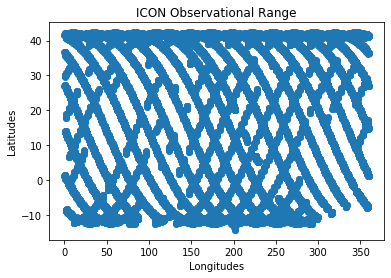

In [11]:
plt.scatter(l23_dict['tang_lon'], l23_dict['tang_lat'])
plt.title("ICON Observational Range")
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
plt.show()


In [112]:
# some helper functions
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def index_of_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

#should search over altitude, not time 
print(index_of_nearest(l23_dict['tang_alt'][3], 95), ", ", find_nearest(l23_dict['tang_alt'][3], 95))

1044 ,  95.56755065917969


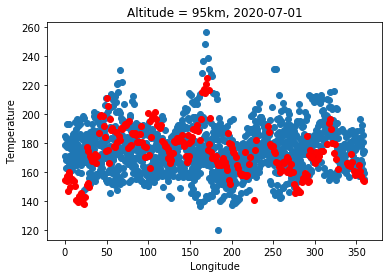

1823
1438
241


In [113]:
# longitude vs temperature for all times, altitude = 95km (all reasonable data points at this altitude)
temperatures, slt15_temps, longitudes, slt15_longs = [], [], [], [] #need to allow for a range
event_count = 0 # helps make sure longitude corresponds to temperature 
for temp in l23_dict['TN'][3]: # row 3 is where alt is closest to 95km 
    event_count += 1
    if temp < 1000 and temp > 100:
        if (np.abs(l23_dict['tang_slt'][3][event_count]-15)) < 1:
            slt15_temps.append(temp)
            slt15_longs.append(l23_dict['tang_lon'][3][event_count])
        else:
            temperatures.append(temp)
            longitudes.append(l23_dict['tang_lon'][3][event_count]) 
plt.scatter(longitudes, temperatures) #tangent longitude vs temperature
plt.scatter(slt15_longs, slt15_temps, color = "red") # points at slt = 15 is red
plt.title("Altitude = 95km, 2020-07-01")
plt.xlabel("Longitude")
plt.ylabel("Temperature")
plt.show()
print(event_count)
print(len(temperatures))
print(len(slt15_temps))
#change color by local time

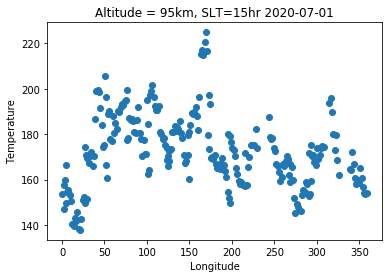

1823
239


In [114]:
# longitude vs temperature for SLT = 15, altitude = 95km (all reasonable data points at this altitude and SLT)
row = 3
temperatures, longitudes = [], [] #need to allow for a range
event_count = 0 # helps make sure longitude corresponds to temperature 
for event in l23_dict['tang_alt'][row]: # row 3 is where alt is closest to 95km 
    if l23_dict['TN'][row][event_count] < 1000 and l23_dict['TN'][row][event_count] > 100 and (np.abs(l23_dict['tang_slt'][row][event_count]-15)) < 1:
        temperatures.append(l23_dict['TN'][row][event_count])
        longitudes.append(l23_dict['tang_lon'][row][event_count]) 
    event_count += 1
plt.scatter(longitudes, temperatures) #tangent longitude vs temperature
plt.title("Altitude = 95km, SLT=15hr 2020-07-01")
plt.xlabel("Longitude")
plt.ylabel("Temperature")
plt.show()
print(event_count)       # should traverse all 1823 events
print(len(temperatures)) # number of points plotted
# put in error bars 

16.94764739938554 0.024051144739837244 -20.372168963296648 0.018873147640721774 170.2177304857795


Text(0, 0.5, 'Temperature')

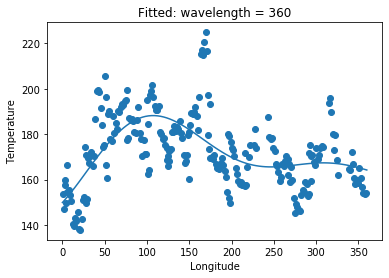

In [142]:
def model(t,A, B, C, D, E):
    return (A*np.sin(B*t) + C*np.cos(D*t) + E)
par0 = [1, 2*np.pi/360, 1, 2*np.pi/360, 170]
par,cov= optimize.curve_fit(model, longitudes, temperatures, p0=par0) 
A, B, C, D, E = par[0], par[1], par[2], par[3], par[4]
print(A, B, C, D, E)
nums = np.linspace(0, 360, 100)
fit1 = model(nums, A, B, C, D, E)
plt.scatter(longitudes, temperatures)
plt.plot(nums, fit1)
plt.title("Fitted: wavelength = 360")
plt.xlabel("Longitude")
plt.ylabel("Temperature")

-4.444604953235259 0.11157719135031537 -11.193717517606922 0.02359295811516737 173.58552615799286


Text(0, 0.5, 'Temperature')

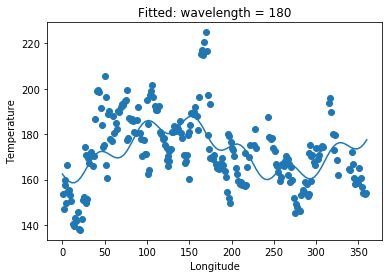

In [143]:
par0 = [1, 2*np.pi/180, 1, 2*np.pi/180, 170]
par,cov= optimize.curve_fit(model, longitudes, temperatures, p0=par0) 
A, B, C, D, E = par[0], par[1], par[2], par[3], par[4]
nums = np.linspace(0, 360, 100)
fit2 = model(nums, A, B, C, D, E)
plt.scatter(longitudes, temperatures)
plt.plot(nums, fit2)
print(A, B, C, D, E)
plt.title("Fitted: wavelength = 180")
plt.xlabel("Longitude")
plt.ylabel("Temperature")

-14.598868202120716 0.05800168755405067 -16.388862199556733 0.06541018877455354 173.87816840797797


Text(0, 0.5, 'Temperature')

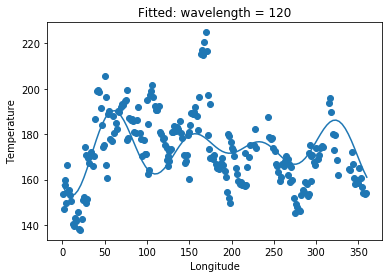

In [128]:
par0 = [-10, 2*np.pi/120, -10, 2*np.pi/120, 170]
par,cov= optimize.curve_fit(model, longitudes, temperatures, p0=par0) 
A, B, C, D, E = par[0], par[1], par[2], par[3], par[4]
nums = np.linspace(0, 360, 100)
fit3 = model(nums, A, B, C, D, E)
plt.scatter(longitudes, temperatures)
plt.plot(nums, fit3)
print(A, B, C, D, E)
plt.title("Fitted: wavelength = 120")
plt.xlabel("Longitude")
plt.ylabel("Temperature")

-12.156113244733312 0.07272190107574697 -8.743718643786917 0.0908733929790149 174.761841549825


Text(0, 0.5, 'Temperature')

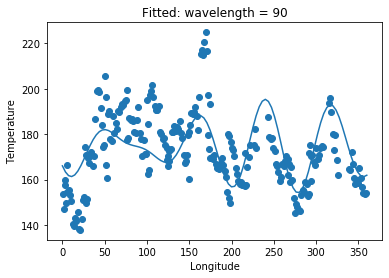

In [129]:
par0 = [1000, 2*np.pi/90, -1000, 2*np.pi/90, 173]
par,cov= optimize.curve_fit(model, longitudes, temperatures, p0=par0) 
A, B, C, D, E = par[0], par[1], par[2], par[3], par[4]
nums = np.linspace(0, 360, 100)
fit4 = model(nums, A, B, C, D, E)
plt.scatter(longitudes, temperatures)
plt.plot(nums, fit4)
print(A, B, C, D, E)
plt.title("Fitted: wavelength = 90")
plt.xlabel("Longitude")
plt.ylabel("Temperature")

-11.914447178654997 0.11077330147108588 10.983481292801407 0.10370751904908083 173.27689722853495


Text(0, 0.5, 'Temperature')

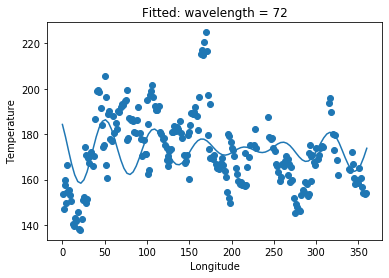

In [130]:
par0 = [-15, 2*np.pi/72, -15, 2*np.pi/72, 170]
par,cov= optimize.curve_fit(model, longitudes, temperatures, p0=par0) 
A, B, C, D, E = par[0], par[1], par[2], par[3], par[4]
nums = np.linspace(0, 360, 100)
fit5 = model(nums, A, B, C, D, E)
plt.scatter(longitudes, temperatures)
plt.plot(nums, fit5)
print(A, B, C, D, E)
plt.title("Fitted: wavelength = 72")
plt.xlabel("Longitude")
plt.ylabel("Temperature")

-9.39681609875108 0.027782576548193022 -15.440535154793746 0.021393454710366938 21.939695609865108 0.027313307815108538 -4.103476633888081 0.021393462015250966


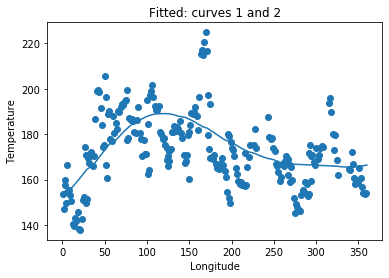

In [131]:
K = 173
def model(t,A, B, C, D, E, F, G, H):
    return (A*np.sin(B*t) + C*np.cos(D*t) + E*np.sin(F*t) + G*np.cos(H*t)+K) 

par0 = [0, 2*np.pi/360, 0, 2*np.pi/360, 0, 2*np.pi/180, 0, 2*np.pi/180]
par,cov= optimize.curve_fit(model, longitudes, temperatures, p0=par0) 
A, B, C, D, E, F, G, H= par[0], par[1], par[2], par[3], par[4], par[5], par[6], par[7]

nums = np.linspace(0, 360, len(temperatures)) # must be 24 to match the length of temperatures 
longitudes_sorted = np.sort(longitudes) # sort longitudes to be in ascending order 
longs_indeces = np.argsort(longitudes) # the order of their indeces (to use to order temperatures)
fit_12 = model(longitudes_sorted, A, B, C, D, E, F, G, H)
plt.scatter(longitudes, temperatures)
plt.plot(nums, fit_12)
plt.title("Fitted: curves 1 and 2")
plt.xlabel("Longitude")
plt.ylabel("Temperature")
print(A, B, C, D, E, F, G, H)

In [132]:
longs_indeces

array([176, 177, 144, 178, 145, 179, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 126, 160, 127, 161, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 108,
       142, 109, 143, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124,  90, 125,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105,  72, 106,  73, 107,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  54,  88,  55,  89,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  36,  71,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  18,  52,
        19,  53,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,   0,  34,   1,  35,   2,   3,   4,   5,   6,   7,
         8,   9,  10,  11,  12,  13, 238,  14,  15,  16,  17, 235, 236,
       237, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 22

In [133]:
# make sure temperatures is in the same order as longitudes
new_temps = []
for i in longs_indeces: 
    new_temps.append(temperatures[i])

In [ ]:
new_temps-fit_12 # should be much smaller than 200 K

0.5831766666089382 0.2633087702986508 -3.1301636821594414 0.05143964506823471 -7.961775497517121 0.07197602257449451 -1.432461251525421 0.05143973485165972


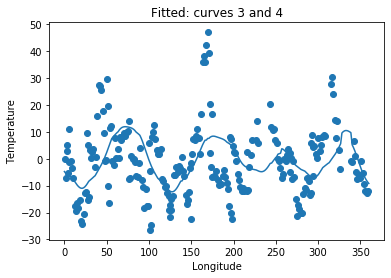

In [135]:
def model(t, I, J, L, M, N, P, Q, R):
    return (I*np.sin(J*t) + L*np.cos(M*t) + N*np.sin(P*t) + Q*np.cos(R*t)) 

par0 = [0, 2*np.pi/120, 0, 2*np.pi/120, 0 , 2*np.pi/90, 0, 2*np.pi/90]
par,cov= optimize.curve_fit(model, longitudes_sorted, new_temps-fit_12, p0=par0) 
I, J, L, M, N, P, Q, R = par[0], par[1], par[2], par[3], par[4], par[5], par[6], par[7]

nums = np.linspace(0, 360, len(temperatures))
fit_34 = model(longitudes_sorted, I, J, L, M, N, P, Q, R)
plt.scatter(longitudes_sorted, new_temps-fit_12)
plt.plot(nums, fit_34)
plt.title("Fitted: curves 3 and 4")
plt.xlabel("Longitude")
plt.ylabel("Temperature")
print(I, J, L, M, N, P, Q, R)

Text(0, 0.5, 'Temperature')

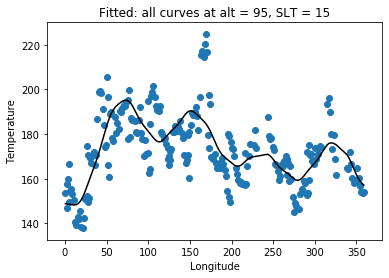

In [136]:
plt.plot(longitudes_sorted, fit_12 + fit_34, c = "black")
plt.scatter(longitudes, temperatures)
plt.title("Fitted: all curves at alt = 95, SLT = 15")
plt.xlabel("Longitude")
plt.ylabel("Temperature")

Text(0, 0.5, 'Temperature')

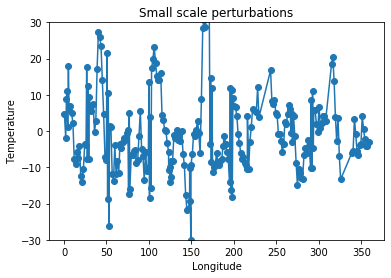

In [137]:
perturbation = (new_temps - (fit_12 + fit_34))
plt.plot(longitudes_sorted, perturbation, '-o')
plt.ylim(-30, 30)
plt.title("Small scale perturbations")
plt.xlabel("Longitude")
plt.ylabel("Temperature")

In [138]:
'''
to do next week: 
- do this at different heights
- make two contour plots
'''

'\nto do next week: \n- do this at different heights\n- make two contour plots\n'

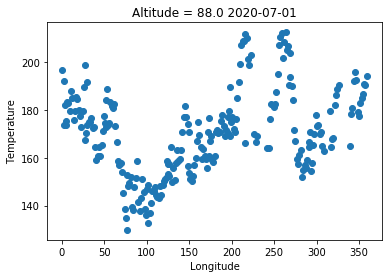

1823
238


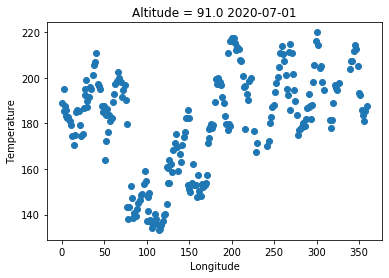

1823
239


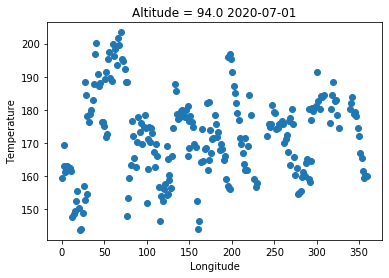

1823
240


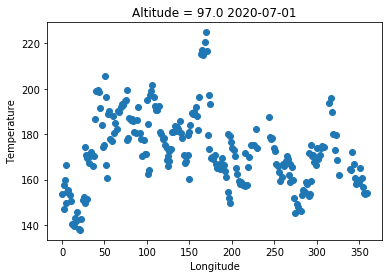

1823
239


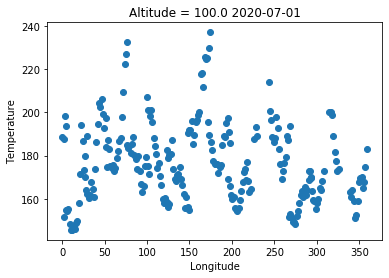

1823
238


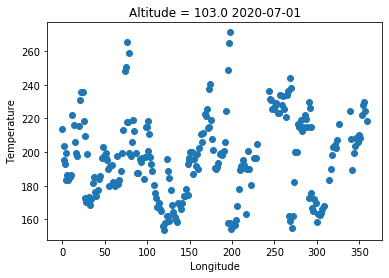

1823
240


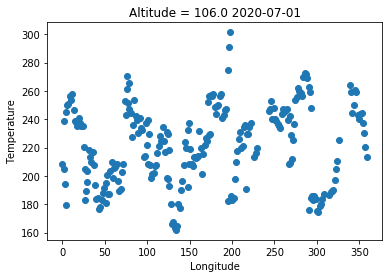

1823
240


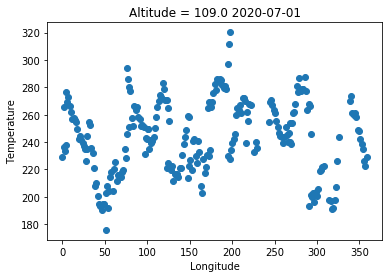

1823
239


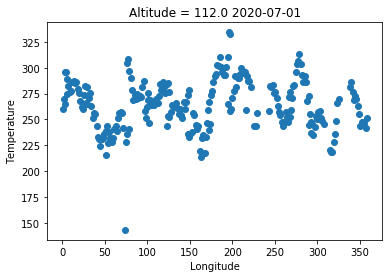

1823
239


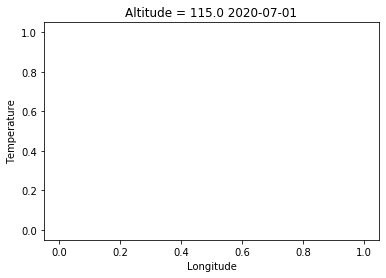

1823
0


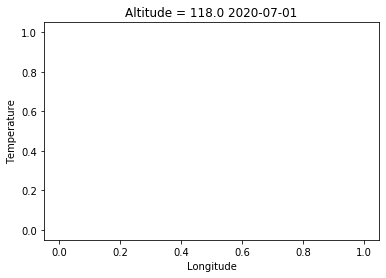

1823
0


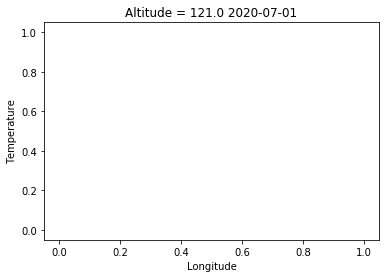

1823
0


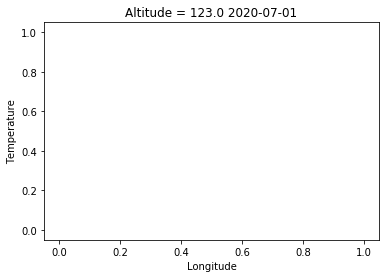

1823
0


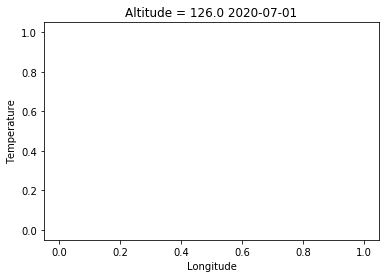

1823
0


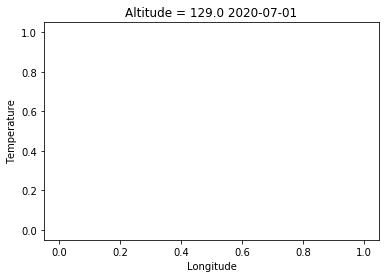

1823
0


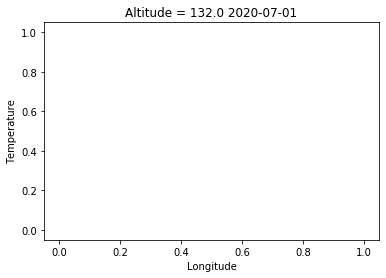

1823
0


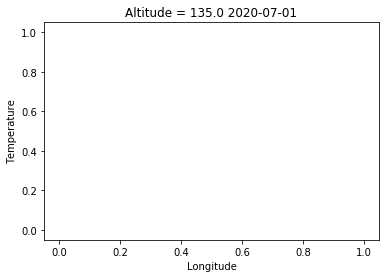

1823
0


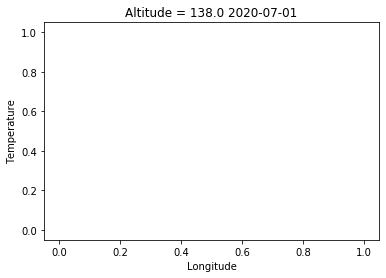

1823
0


In [34]:
# scatter plot of long vs temp, slt = 15, all altitudes 
row = 0
slt = 15
all_temps = []
all_longs = []
all_alts = []
rows = []
for alt in l23_dict['tang_alt']: # seems like higher altitudes tend to have extreme temperatures
    temperatures, longitudes, alts = [], [], [] 
    event_count = 0 # helps make sure longitude corresponds to temperature 
    for event in l23_dict['tang_alt'][row]: # row 3 is where alt is closest to 95km 
        if l23_dict['TN'][row][event_count] < 1000 and l23_dict['TN'][row][event_count] > 100 and (np.abs(l23_dict['tang_slt'][row][event_count]-slt)) < 1:
            temperatures.append(l23_dict['TN'][row][event_count])
            longitudes.append(l23_dict['tang_lon'][row][event_count])
            alts.append(l23_dict['tang_alt'][row][event_count])
        event_count += 1
    plt.scatter(longitudes, temperatures) #tangent longitude vs temperature
    plt.title("Altitude = " + str(np.average(l23_dict['tang_alt'][row])//1) + " 2020-07-01")
    plt.xlabel("Longitude")
    plt.ylabel("Temperature")
    plt.show()
    print(event_count)       # should traverse all 1823 events
    print(len(temperatures)) # number of points plotted
    row += 1
    if temperatures: # if there are any non-extreme values (between 100 and 1000 K) at that altitude
        all_temps.append(temperatures)
        all_longs.append(longitudes)
        all_alts.append(alts)
        rows.append(row)

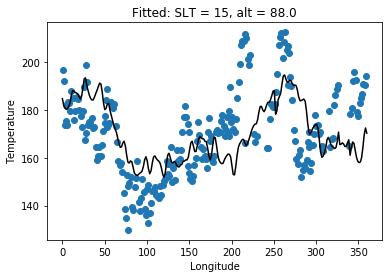

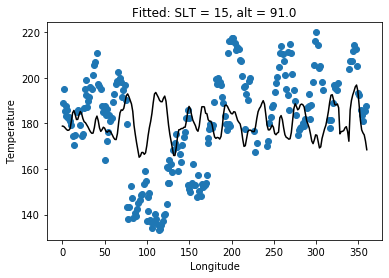

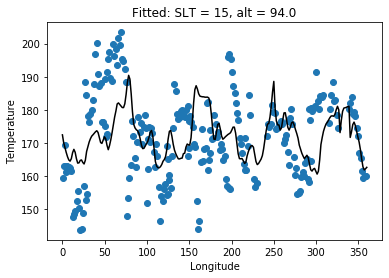

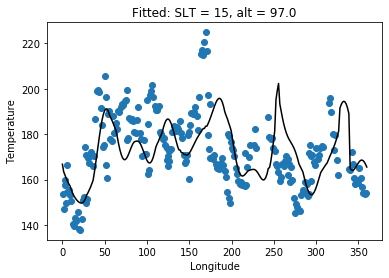

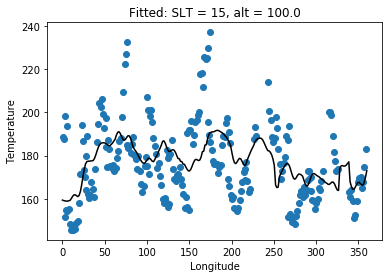

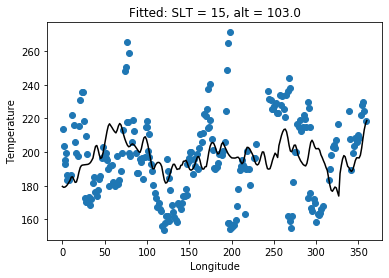

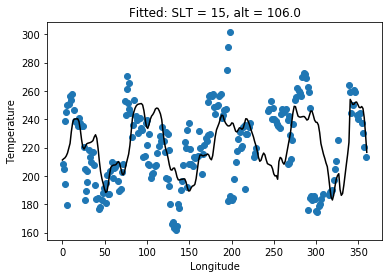

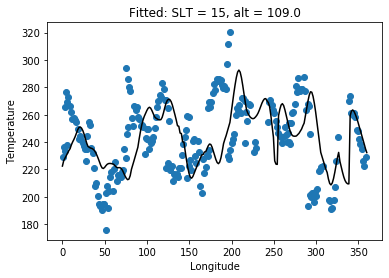

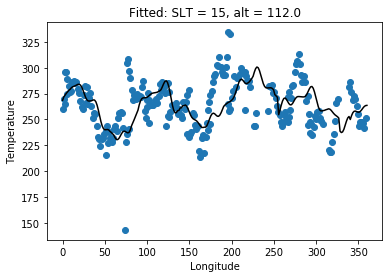

In [107]:
# fitted at various altitudes, slt = 15
index = 0
def model(t,A, B, C, D, E, F, G, H, I, J, K, L, M, N, P, Q, R, S, T, U, V):
        return (A*np.sin(B*t) + C*np.cos(D*t) + E*np.sin(F*t) + G*np.cos(H*t)+ I*np.sin(J*t) + L*np.cos(M*t) + N*np.sin(P*t) + Q*np.cos(R*t) + S*np.sin(T*t) + U*np.cos(V*t) + K) 
fits = []  
for r in rows:
    row = rows[index]
    temperatures = all_temps[index]
    longitudes = all_longs[index]
    par0 = [1, 2*np.pi/360, 1, 2*np.pi/360, 1, 2*np.pi/180, 1, 2*np.pi/180, 1, 2*np.pi/120, 1, 1, 2*np.pi/120, 1, 2*np.pi/90, 1, 2*np.pi/90, 1, 2*np.pi/72, 1, 2*np.pi/72]
    par,cov= optimize.curve_fit(model, longitudes, temperatures, p0 = par0, maxfev = 10000000) 
    A, B, C, D, E, F, G, H, I, J, K, L, M, N, P, Q, R, S, T, U, V = par[0], par[1], par[2], par[3], par[4], par[5], par[6], par[7], par[8], par[9], par[10], par[11], par[12], par[13], par[14], par[15], par[16], par[17], par[18], par[19], par[20]
    nums = np.linspace(0, 360, len(temperatures)) # must match the length of temperatures 
    longitudes_sorted = np.sort(longitudes) # sort longitudes to be in ascending order 
    longs_indeces = np.argsort(longitudes) # the order of their indeces (to use to order temperatures)
    fit = model(longitudes_sorted, A, B, C, D, E, F, G, H, I, J, K, L, M, N, P, Q, R, S, T, U, V)
    fits.append(fit)
    plt.scatter(longitudes, temperatures)
    plt.plot(nums, fit,  c = "black")
    plt.title("Fitted: SLT = 15, alt = " +  str(np.average(l23_dict['tang_alt'][index])//1))
    plt.xlabel("Longitude")
    plt.ylabel("Temperature")
    plt.show()
    index += 1

In [108]:
len(temperatures)

239

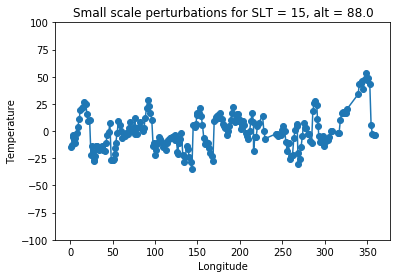

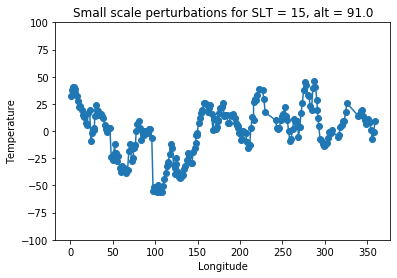

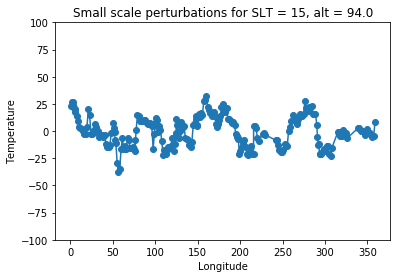

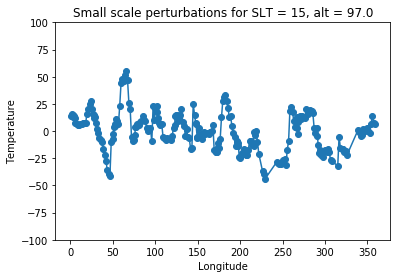

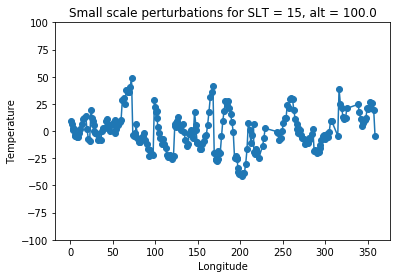

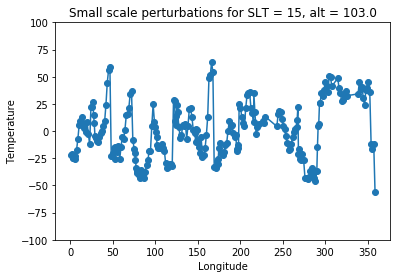

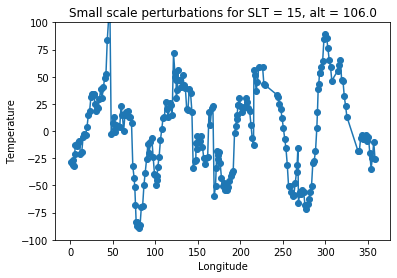

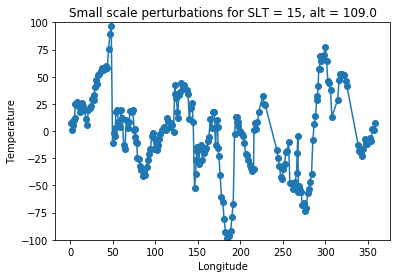

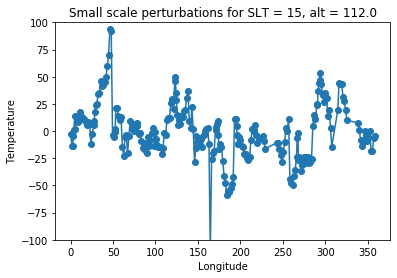

In [109]:
index = 0
all_perts = []
for row in rows:
    perturbation = (all_temps[index] - fits[index])
    all_perts.append(perturbation)
    plt.plot(np.sort(all_longs[index]), perturbation, '-o')
    plt.ylim(-100, 100)
    plt.title("Small scale perturbations for SLT = 15, alt = " +  str(np.average(l23_dict['tang_alt'][index])//1))
    plt.xlabel("Longitude")
    plt.ylabel("Temperature")
    plt.show()
    index += 1

In [46]:
# helper function to pad arrays with uneven rows; makes all rows the same length
def pad(m):
    maxlen = 240 # max(len(r) for r in m)
    z = np.zeros((len(m), maxlen))
    for enu, row in enumerate(m):
        z[enu, :len(row)] += row 
    return z

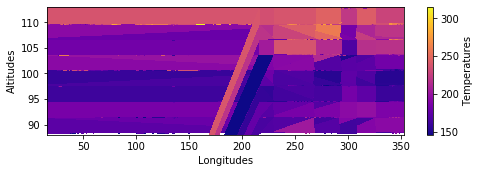

In [47]:
fig,ax=plt.subplots(figsize=(8,8))#fig=pp.figure(figsize=(12,10)
gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,1]) 
ax0 = plt.subplot(gs[0,0])
temps_padded = pad(all_temps)
longs_padded = pad(all_longs)
alts_padded = pad(all_alts)
im = ax0.pcolor(longs_padded, alts_padded, temps_padded, cmap = 'plasma', vmin = 146, vmax = 315)#,norm=colors.Normalize(vmin=0, vmax=150))
ax0.axis([16,353,88,113])
ax0.set_title("")
ax0.set_xlabel("Longitudes")
ax0.set_ylabel("Altitudes")
color_bar=fig.colorbar(im)
color_bar.set_label("Temperatures")
# turns out can't really make a contour plot with this data - need to interpolate longitudes? 


In [48]:
# plot all perturbations line plots in one graph

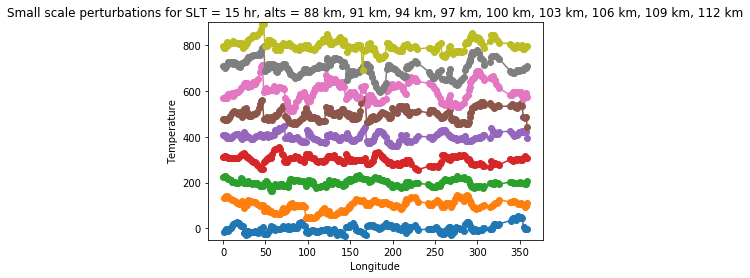

In [53]:
index = 0
for pert in all_perts: 
    plt.plot(np.sort(all_longs[index]), pert + 100*index, '-o')
    plt.ylim(-50, 900)
    index += 1
    plt.title("Small scale perturbations for SLT = 15 hr, alts = 88 km, 91 km, 94 km, 97 km, 100 km, 103 km, 106 km, 109 km, 112 km")
    plt.xlabel("Longitude")
    plt.ylabel("Temperature")
plt.show()
#next: different local time
# put any of the lines (each altitude) in a 20 degree longitude bin 
# create local time loop 
# T' = T - T(wavenumber 1 to 5) 
# take what i have, square it, sort into longitudinal bins 
# should grid the amplitudes of the waves 
# choose one altitude to do at different local times
# contour plot of local time vs longitude with the temperatures squared (slt is already bins) (x will be 20 degree longitude, y is hourly local time, some slt might be missing can ignore)


In [77]:
4.14e-15 * 3e17 / 1.65

752.7272727272727

In [ ]:
# creating functions to avoid tons of the same code 

In [164]:
# scatter plots
def scatter_all_alts(alts_dict, long_dict, temps_dict, slt): 
    row = 0
    all_temps = []
    all_longs = []
    all_alts = []
    rows = []
    for alt in l23_dict['tang_alt']: # seems like higher altitudes tend to have extreme temperatures
        temperatures, longitudes, alts = [], [], [] 
        event_count = 0 # helps make sure longitude corresponds to temperature 
        for event in l23_dict['tang_alt'][row]: # row 3 is where alt is closest to 95km 
            if l23_dict['TN'][row][event_count] < 1000 and l23_dict['TN'][row][event_count] > 100 and (np.abs(l23_dict['tang_slt'][row][event_count]-slt)) < 0.1:
                temperatures.append(l23_dict['TN'][row][event_count])
                longitudes.append(l23_dict['tang_lon'][row][event_count])
                alts.append(l23_dict['tang_alt'][row][event_count])
            event_count += 1
        plt.scatter(longitudes, temperatures) #tangent longitude vs temperature
        plt.title("Altitude = " + str(np.average(l23_dict['tang_alt'][row])//1) + " 2020-07-01")
        plt.xlabel("Longitude")
        plt.ylabel("Temperature")
        plt.show()
        print(event_count)       # should traverse all 1823 events
        print(len(temperatures)) # number of points plotted
        row += 1
        if temperatures: # if there are any non-extreme values (between 100 and 1000 K) at that altitude
            all_temps.append(temperatures)
            all_longs.append(longitudes)
            all_alts.append(alts)
            rows.append(row)
    return [all_temps, all_alts, all_longs, rows]
        
# fitted at various altitudes
def fitted_all_alts(all_temps_alts_longs_rows, slt):
    index = 0
    def model(t,A, B, C, D, E, F, G, H, I, J, K, L, M, N, P, Q, R, S, T, U, V):
            return (A*np.sin(B*t) + C*np.cos(D*t) + E*np.sin(F*t) + G*np.cos(H*t)+ I*np.sin(J*t) + L*np.cos(M*t) + N*np.sin(P*t) + Q*np.cos(R*t) + S*np.sin(T*t) + U*np.cos(V*t) + K) 
    fits = []  
    for r in all_temps_alts_longs_rows[3]:
        row = all_temps_alts_longs_rows[3][index]
        temperatures = all_temps_alts_longs_rows[0][index]
        longitudes = all_temps_alts_longs_rows[2][index]
        par0 = [1, 2*np.pi/360, 1, 2*np.pi/360, 1, 2*np.pi/180, 1, 2*np.pi/180, 1, 2*np.pi/120, 1, 1, 2*np.pi/120, 1, 2*np.pi/90, 1, 2*np.pi/90, 1, 2*np.pi/72, 1, 2*np.pi/72]
        par,cov= optimize.curve_fit(model, longitudes, temperatures, p0 = par0, maxfev = 10000000) 
        A, B, C, D, E, F, G, H, I, J, K, L, M, N, P, Q, R, S, T, U, V = par[0], par[1], par[2], par[3], par[4], par[5], par[6], par[7], par[8], par[9], par[10], par[11], par[12], par[13], par[14], par[15], par[16], par[17], par[18], par[19], par[20]
        nums = np.linspace(0, 360, len(temperatures)) # must match the length of temperatures 
        longitudes_sorted = np.sort(longitudes) # sort longitudes to be in ascending order 
        longs_indeces = np.argsort(longitudes) # the order of their indeces (to use to order temperatures)
        fit = model(longitudes_sorted, A, B, C, D, E, F, G, H, I, J, K, L, M, N, P, Q, R, S, T, U, V)
        fits.append(fit)
        plt.scatter(longitudes, temperatures)
        plt.plot(nums, fit,  c = "black")
        plt.title("Fitted: SLT = " + str(slt) + ", alt = " +  str(np.average(l23_dict['tang_alt'][index])//1))
        plt.xlabel("Longitude")
        plt.ylabel("Temperature")
        plt.show()
        index += 1
    return fits

# perturbations 
def plot_perturbations(all_temps_alts_longs_rows, fits, slt): 
    index = 0
    all_perts = []
    for row in all_temps_alts_longs_rows[3]:
        perturbation = (all_temps_alts_longs_rows[0][index] - fits[index])
        all_perts.append(perturbation)
        plt.plot(np.sort(all_temps_alts_longs_rows[2][index]), perturbation, '-o')
        plt.ylim(-100, 100)
        plt.title("Small scale perturbations for SLT = " + str(slt) + ", alt = " +  str(np.average(all_temps_alts_longs_rows[1][index])//1))
        plt.xlabel("Longitude")
        plt.ylabel("Temperature")
        plt.show()
        index += 1
    return all_perts

# plot all perturbations together 
def plot_all_perts(all_temps_alts_longs_rows, all_perts, slt): 
    index = 0
    for pert in all_perts: 
        plt.plot(np.sort(all_temps_alts_longs_rows[2][index]), pert + 60*index, '-o')
        plt.ylim(-50, 550)
        index += 1
        plt.title("Small scale perturbations for SLT = " + str(slt) + "hr, alts = 88 km, 91 km, 94 km, 97 km, 100 km, 103 km, 106 km, 109 km, 112 km")
        plt.xlabel("Longitude")
        plt.ylabel("Temperature")
    plt.show()

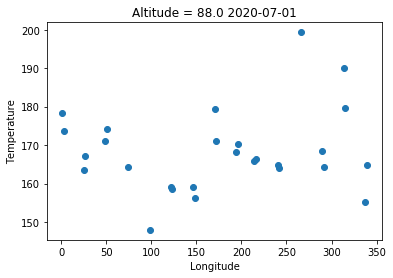

1823
27


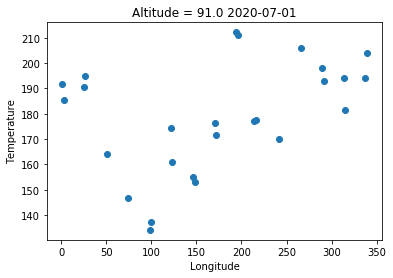

1823
26


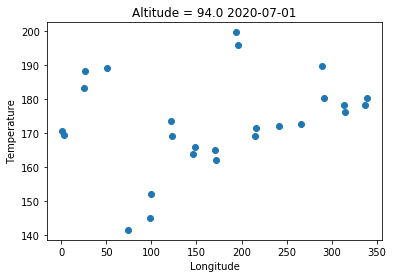

1823
26


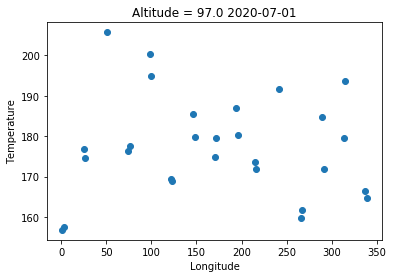

1823
28


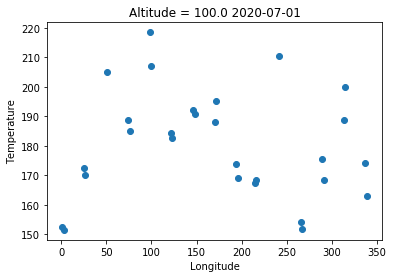

1823
28


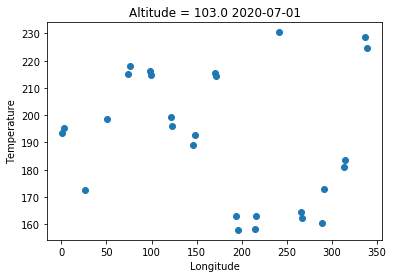

1823
27


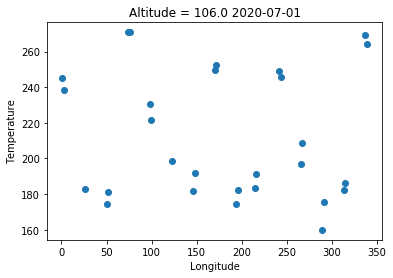

1823
28


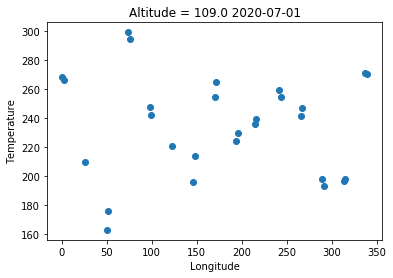

1823
28


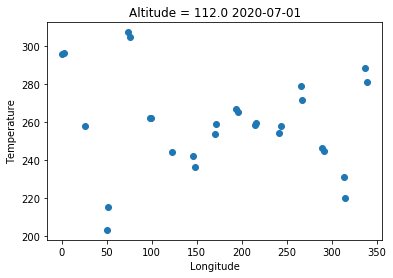

1823
28


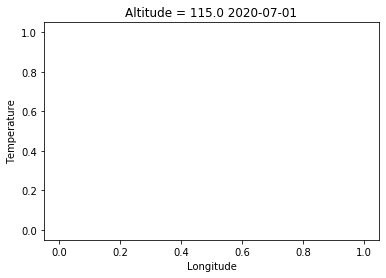

1823
0


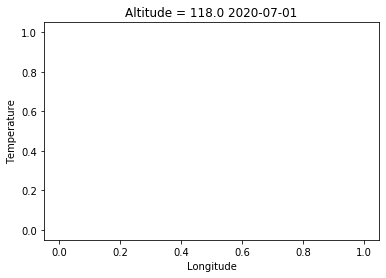

1823
0


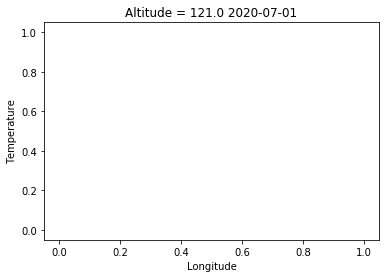

1823
0


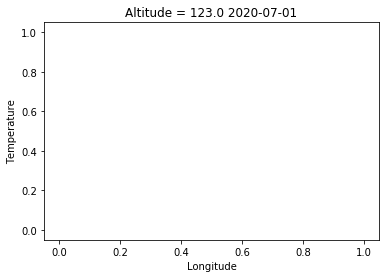

1823
0


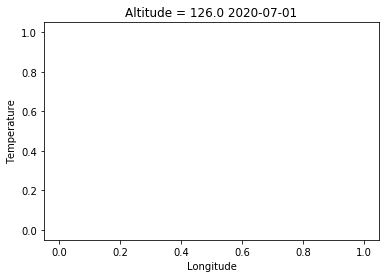

1823
0


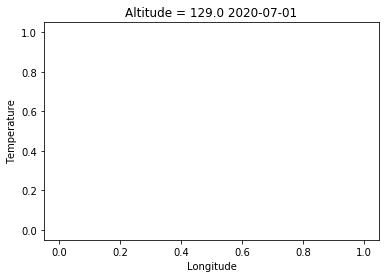

1823
0


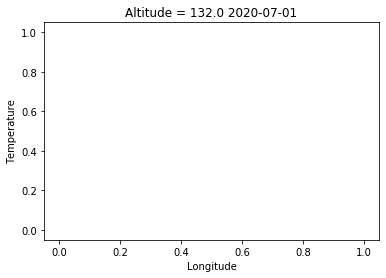

1823
0


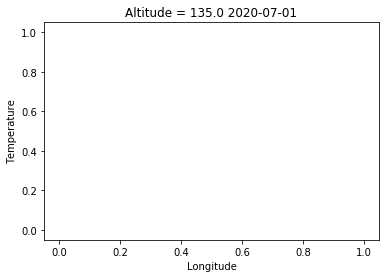

1823
0


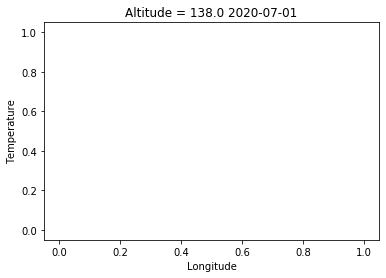

1823
0


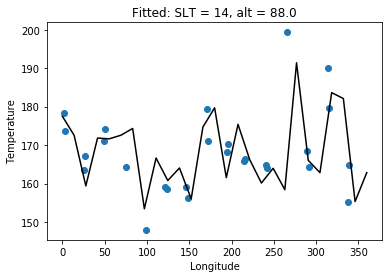

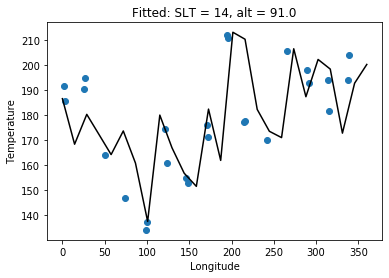

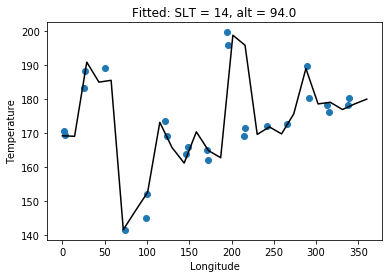

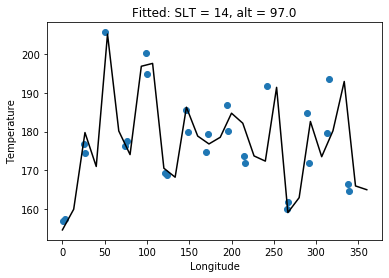

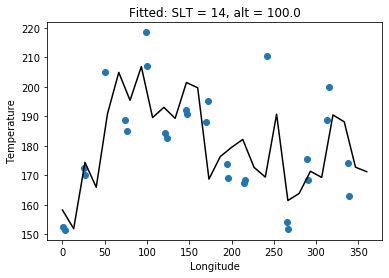

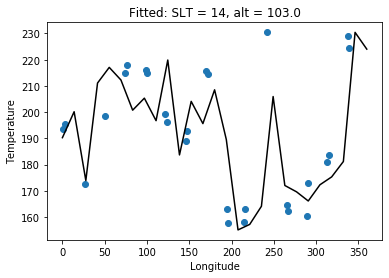

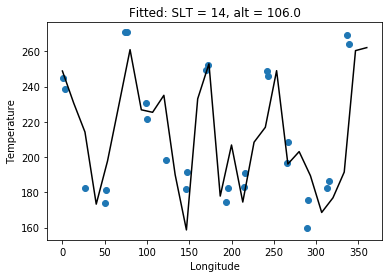

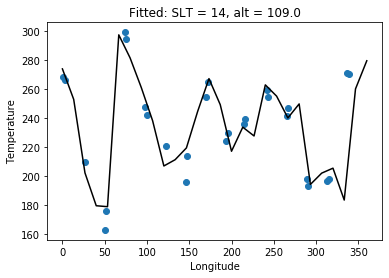

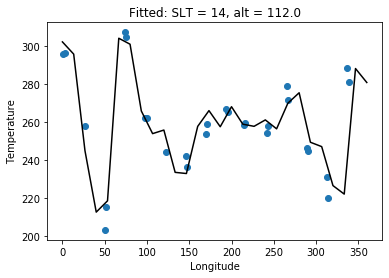

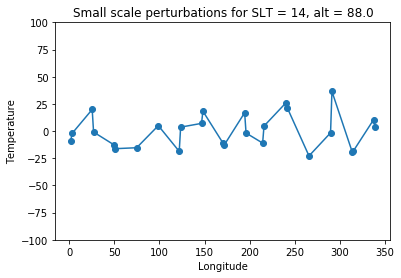

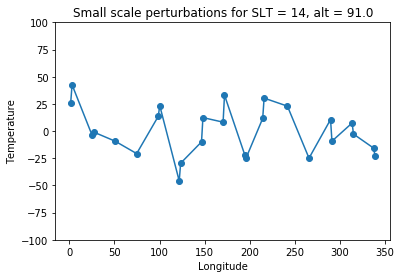

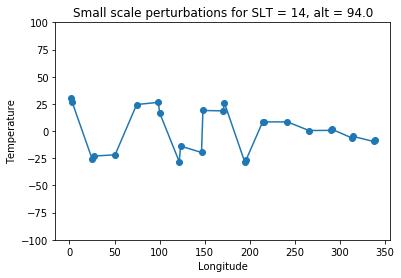

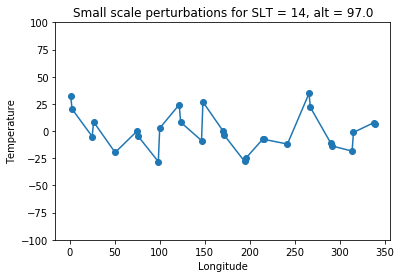

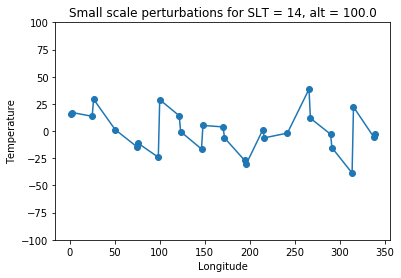

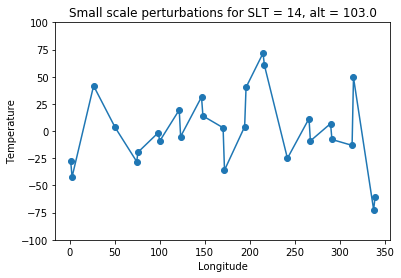

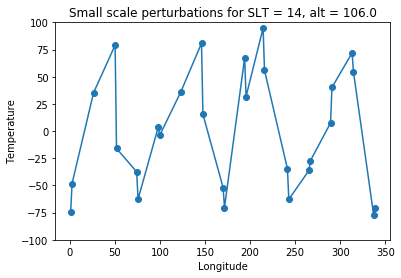

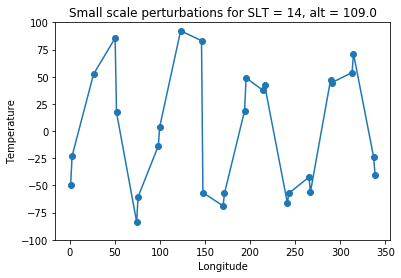

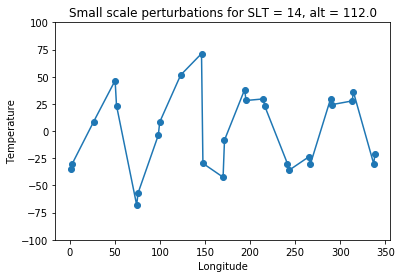

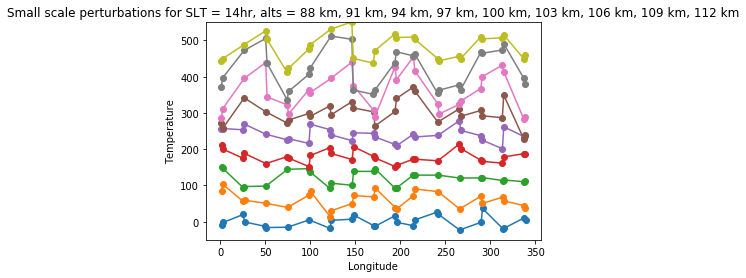

In [169]:
alts_dict = l23_dict['tang_alt']
long_dict = l23_dict['tang_lon']
temps_dict = l23_dict['TN']
slt = 14
all_temps_alts_longs_rows = scatter_all_alts(alts_dict, long_dict, temps_dict, slt)
fits = fitted_all_alts(all_temps_alts_longs_rows, slt)
all_perts =  plot_perturbations(all_temps_alts_longs_rows, fits, slt)
plot_all_perts(all_temps_alts_longs_rows, all_perts, slt)

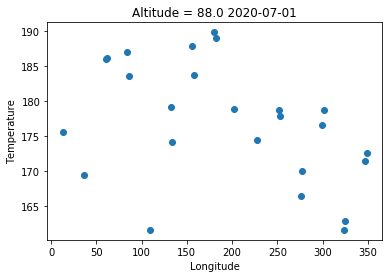

1823
25


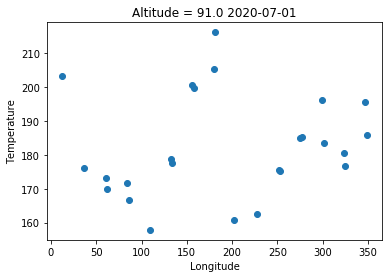

1823
25


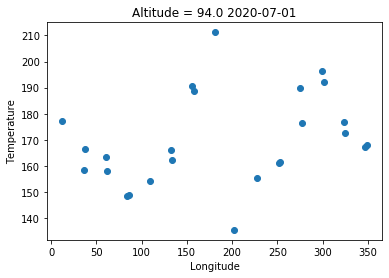

1823
25


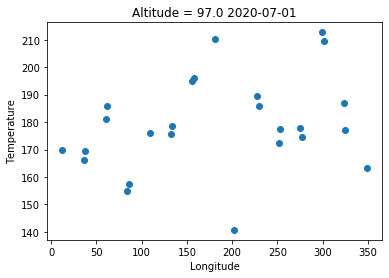

1823
25


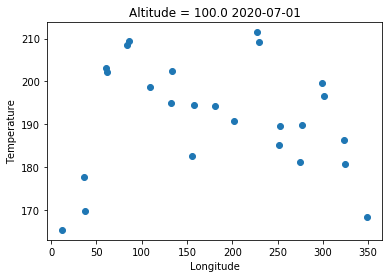

1823
25


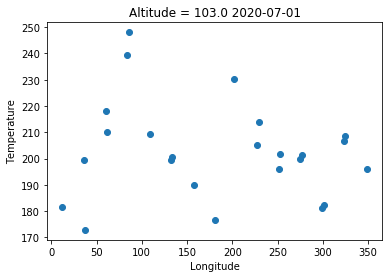

1823
24


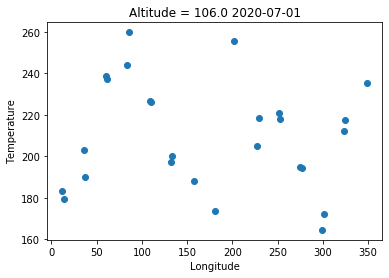

1823
26


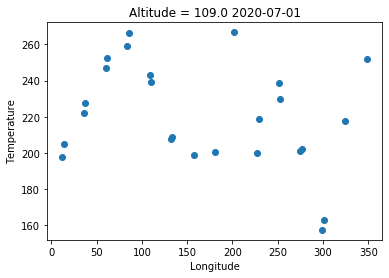

1823
25


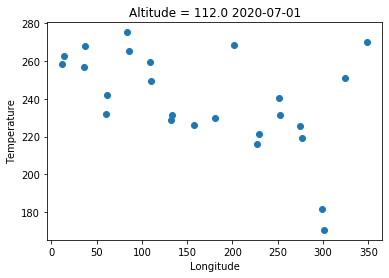

1823
25


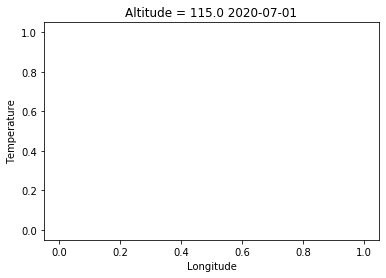

1823
0


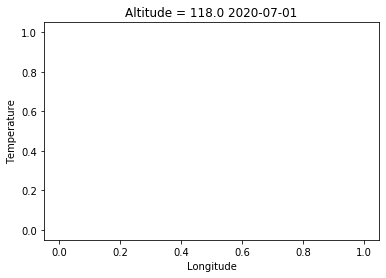

1823
0


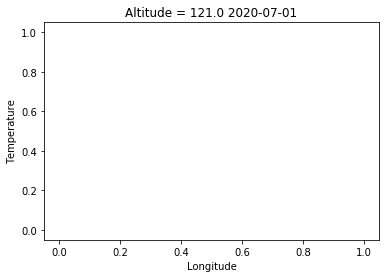

1823
0


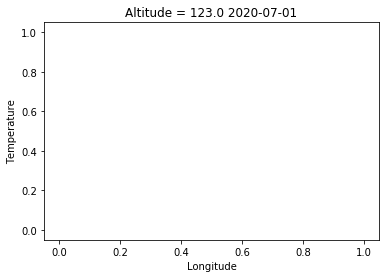

1823
0


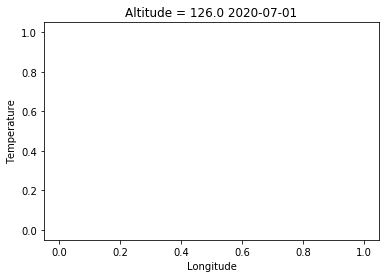

1823
0


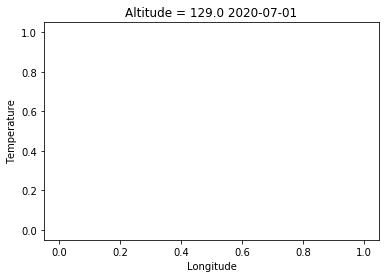

1823
0


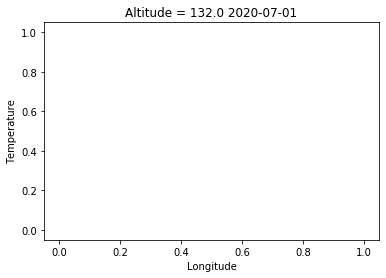

1823
0


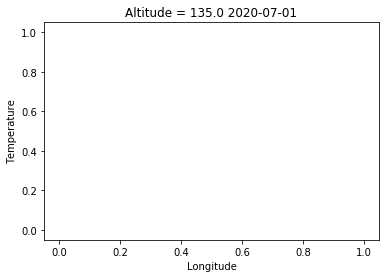

1823
0


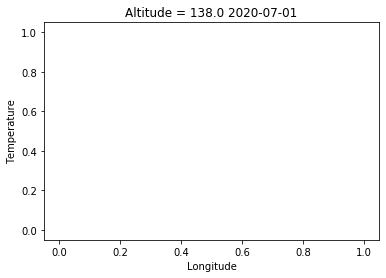

1823
0


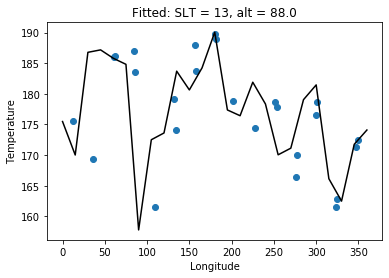

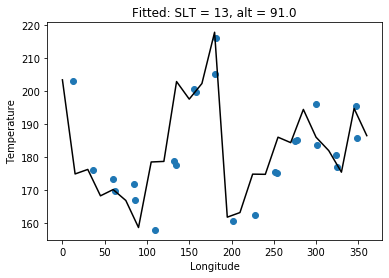

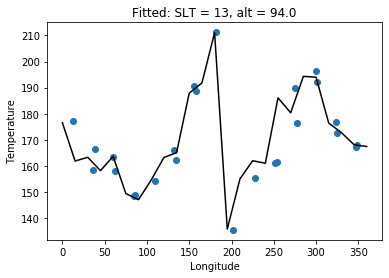

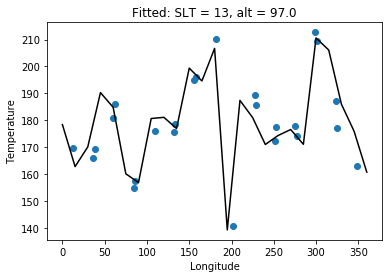

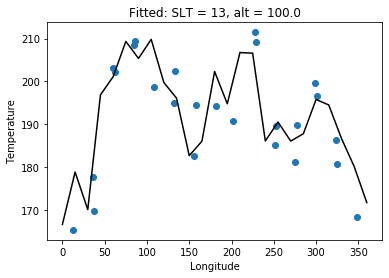

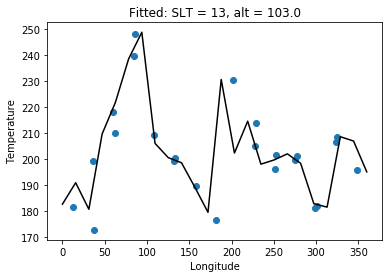

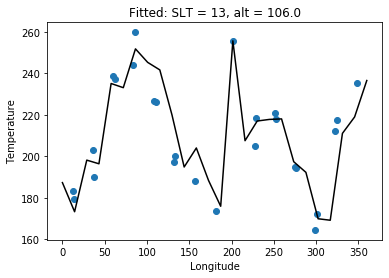

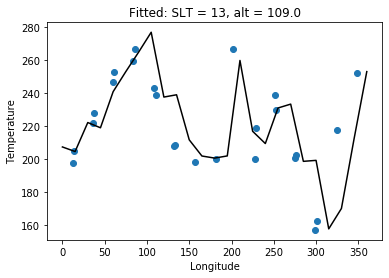

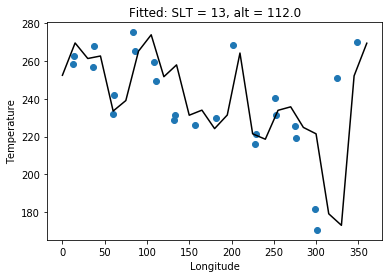

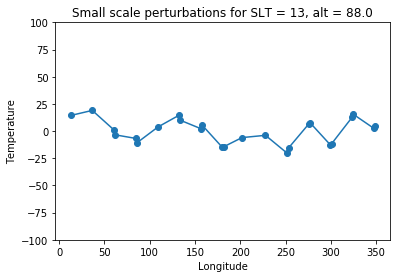

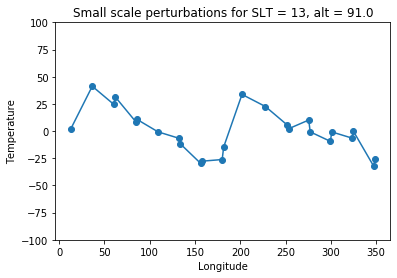

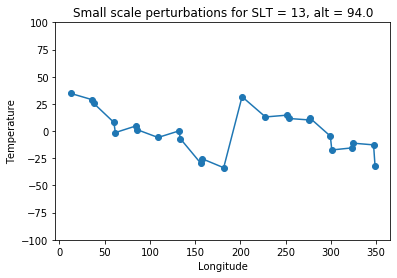

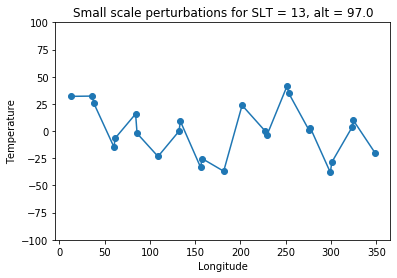

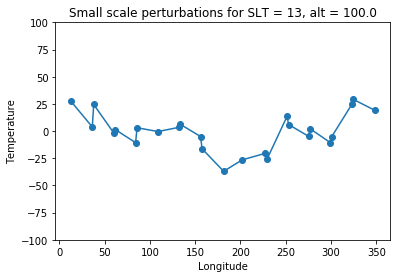

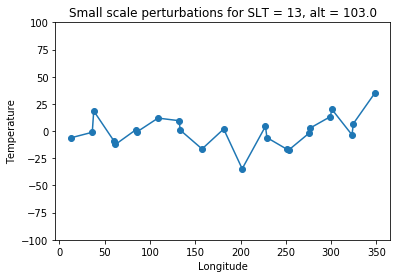

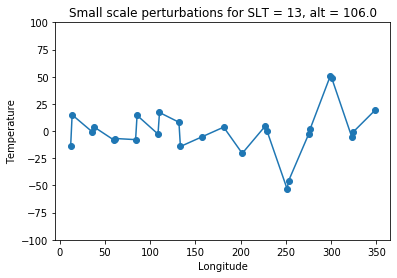

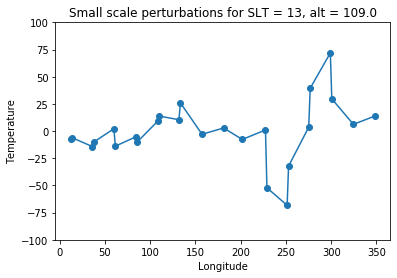

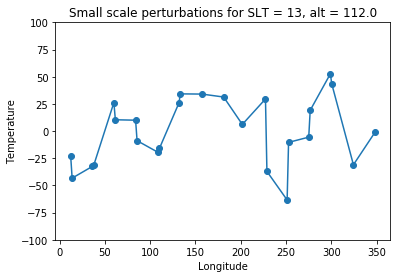

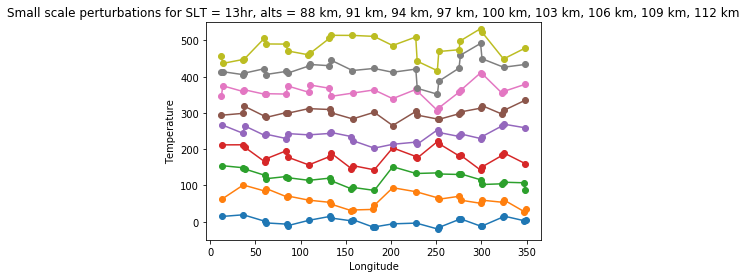

In [173]:
alts_dict = l23_dict['tang_alt']
long_dict = l23_dict['tang_lon']
temps_dict = l23_dict['TN']
slt = 13
all_temps_alts_longs_rows = scatter_all_alts(alts_dict, long_dict, temps_dict, slt)
fits = fitted_all_alts(all_temps_alts_longs_rows, slt)
all_perts =  plot_perturbations(all_temps_alts_longs_rows, fits, slt)
plot_all_perts(all_temps_alts_longs_rows, all_perts, slt)

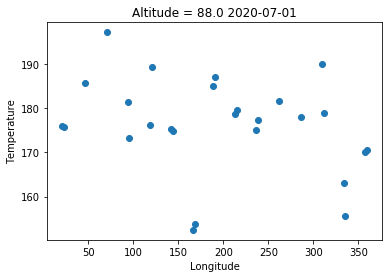

1823
26


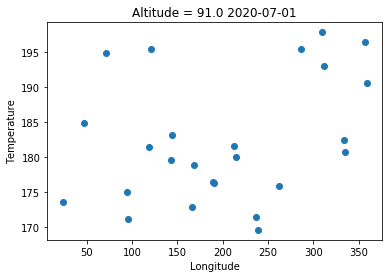

1823
25


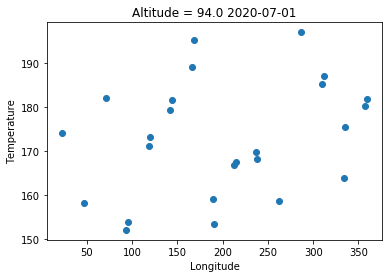

1823
25


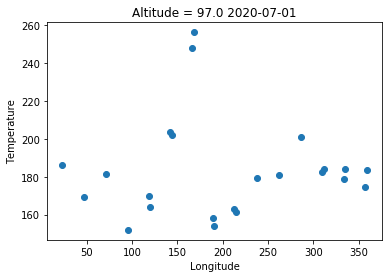

1823
23


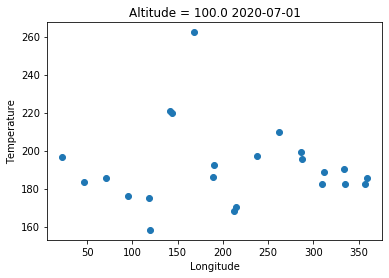

1823
23


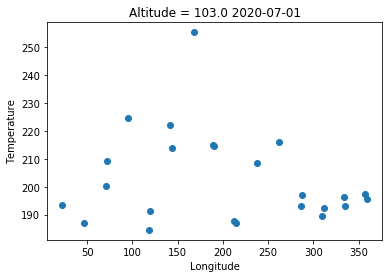

1823
24


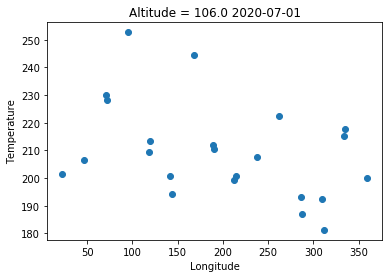

1823
23


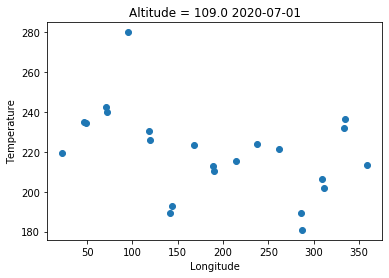

1823
23


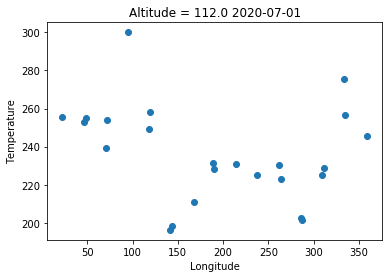

1823
24


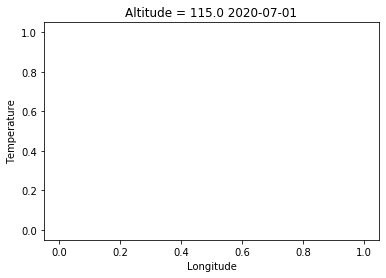

1823
0


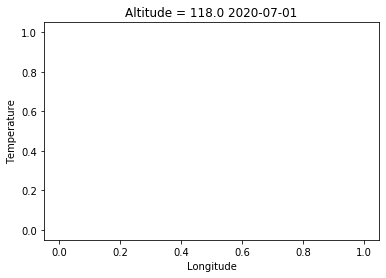

1823
0


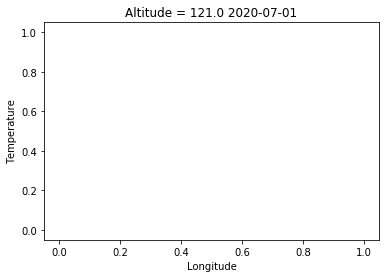

1823
0


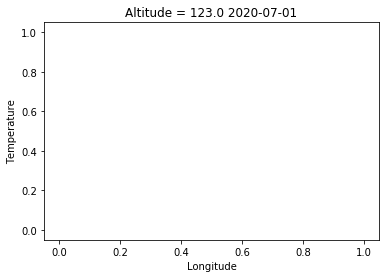

1823
0


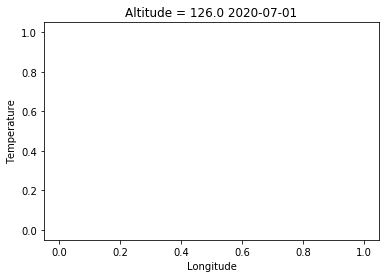

1823
0


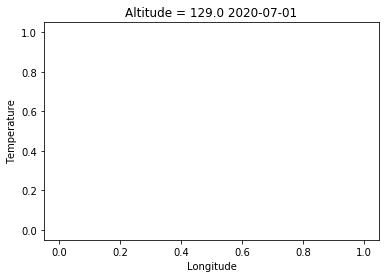

1823
0


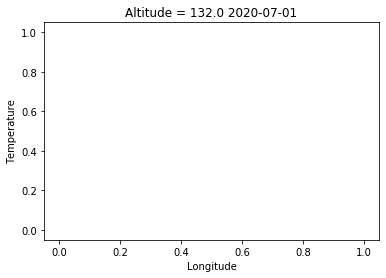

1823
0


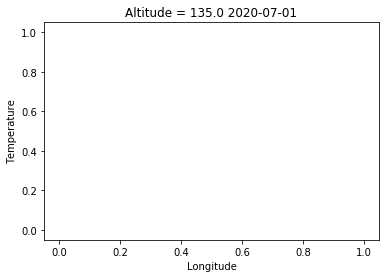

1823
0


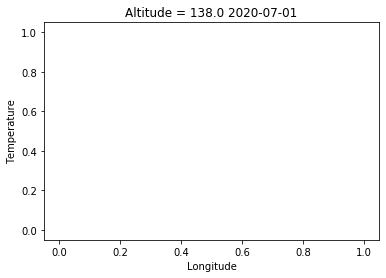

1823
0


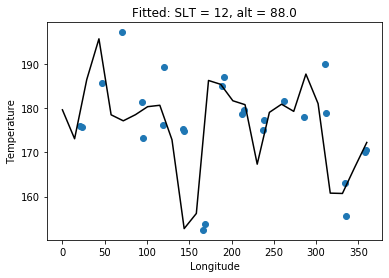

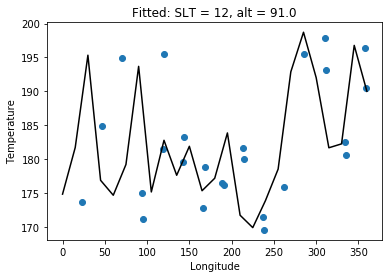

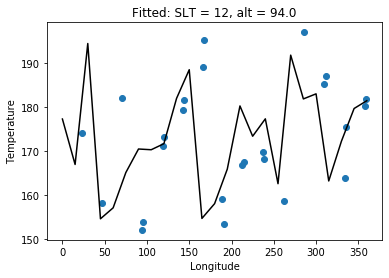

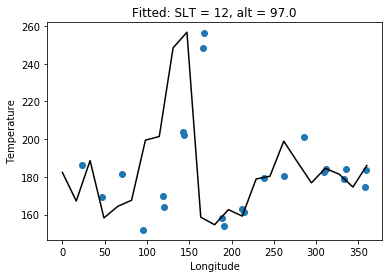

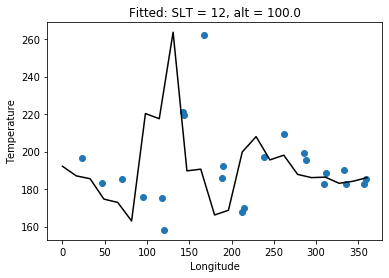

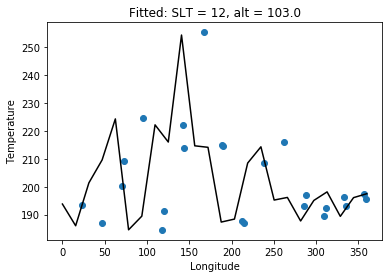

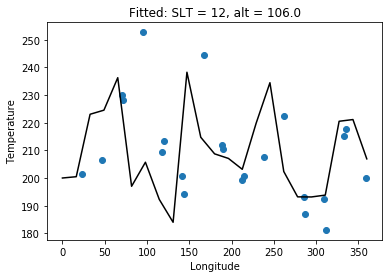

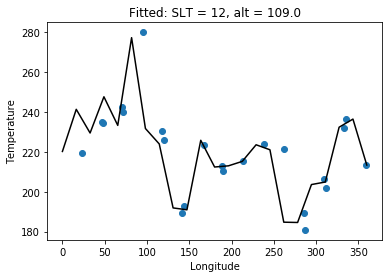

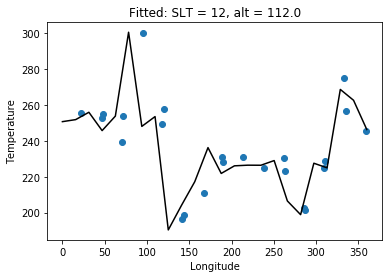

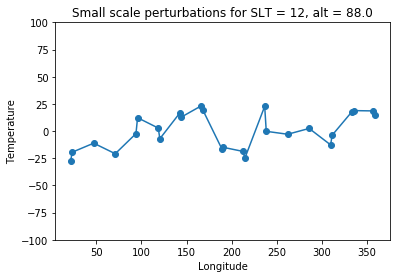

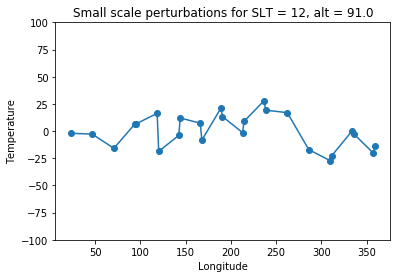

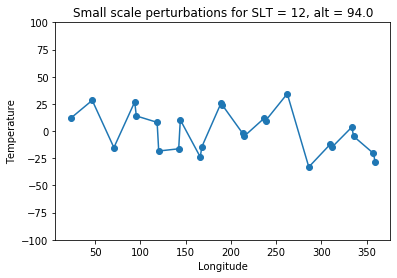

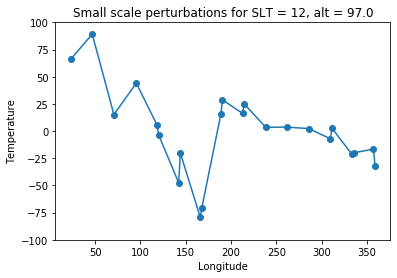

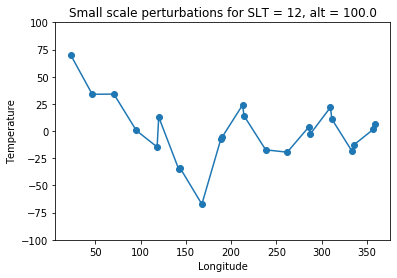

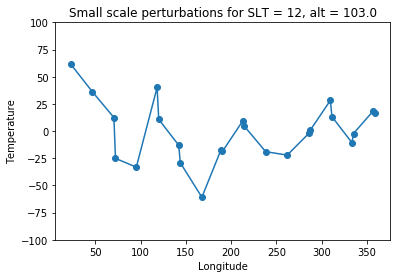

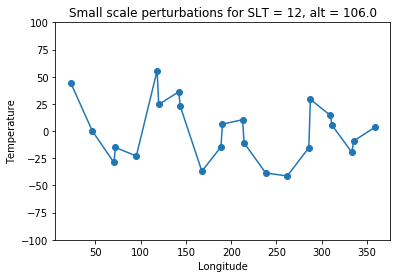

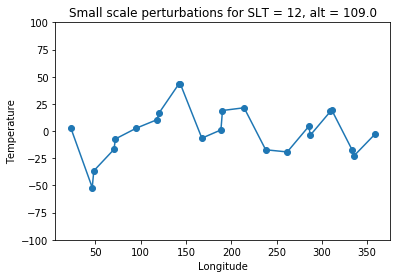

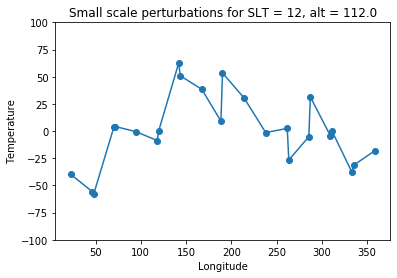

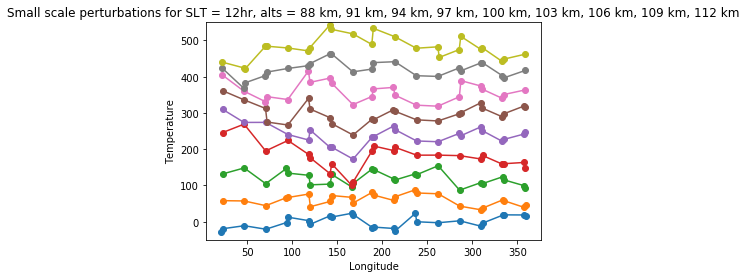

In [174]:
alts_dict = l23_dict['tang_alt']
long_dict = l23_dict['tang_lon']
temps_dict = l23_dict['TN']
slt = 12
all_temps_alts_longs_rows = scatter_all_alts(alts_dict, long_dict, temps_dict, slt)
fits = fitted_all_alts(all_temps_alts_longs_rows, slt)
all_perts =  plot_perturbations(all_temps_alts_longs_rows, fits, slt)
plot_all_perts(all_temps_alts_longs_rows, all_perts, slt)

In [33]:
from mpl_toolkits.basemap import Basemap

In [32]:
import os

os.environ['PROJ_LIB'] = r'/Users/shreyanagpal/anaconda3/share/basemap/'


In [336]:
netCDF4.Dataset("ICON_L2-3_MIGHTI-A_Temperature_2020-07-01_v03r000.NC")

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Acknowledgement: This is a data product from the NASA Ionospheric Connection Explorer mission, an Explorer launched at 21:59:45 EDT on October 10, 2019, from Cape Canaveral AFB in the USA. Guidelines for the use of this product are described in the ICON Rules of the Road  (http://icon.ssl.berkeley.edu/Data).

Responsibility for the mission science falls to the Principal Investigator, Dr. Thomas Immel at UC Berkeley:
 Immel, T.J., England, S.L., Mende, S.B. et al. Space Sci Rev (2018) 214: 13. https://doi.org/10.1007/s11214-017-0449-2

Responsibility for the validation of the L1 data products falls to the instrument lead investigators/scientists.
 * EUV: Dr. Eric Korpela :  https://doi.org/10.1007/s11214-017-0384-2
 * FUV: Dr. Harald Frey : https://doi.org/10.1007/s11214-017-0386-0
 * MIGHTI: Dr. Christoph Englert : https://doi.org/10.1007/s11214-017-0358-4, and https://doi.org/10.1007/s11214-017-0